<h1>Taxi Demand Prediction</h1>

http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml 

<h3> DATA DICTIONARY </h3>
<table>
<th>Field Name <th>Description
<tr> <td>VendorID <td>A code indicating the TPEP provider that provided the record.
1= Creative Mobile Technologies, LLC; 2= VeriFone Inc.
<tr>
<td>tpep_pickup_datetime <td> The date and time when the meter was engaged.
<tr>
<td>tpep_dropoff_datetime <td>The date and time when the meter was disengaged.
<tr>
<td>Passenger_count <td>The number of passengers in the vehicle.
This is a driver-entered value.
<tr>
<td>Trip_distance <td>The elapsed trip distance in miles reported by the taximeter.
<tr>
<td>PULocationID <td>TLC Taxi Zone in which the taximeter was engaged
<tr><td>DOLocationID <td>TLC Taxi Zone in which the taximeter was disengaged
<tr><td>RateCodeID <td>The final rate code in effect at the end of the trip.
1= Standard rate
2=JFK
3=Newark
4=Nassau or Westchester
5=Negotiated fare
6=Group ride
<tr>
<td>Store_and_fwd_flag <td>This flag indicates whether the trip record was held in vehicle
memory before sending to the vendor, aka “store and forward,”
because the vehicle did not have a connection to the server.
Y= store and forward trip
N= not a store and forward trip
<tr>
<td>Payment_type <td>A numeric code signifying how the passenger paid for the trip.
1= Credit card
2= Cash
3= No charge
4= Dispute
5= Unknown
6= Voided trip
<tr><td>
Fare_amount <td>The time-and-distance fare calculated by the meter.
<tr><td>
Extra <td>Miscellaneous extras and surcharges. Currently, this only includes
the $0.50 and $1 rush hour and overnight charges.
<tr><td>
MTA_tax <td>$0.50 MTA tax that is automatically triggered based on the metered
rate in use.
<tr><td>
Improvement_surcharge <td>$0.30 improvement surcharge assessed trips at the flag drop. The
improvement surcharge began being levied in 2015.
<tr><td>
Tip_amount <td>Tip amount – This field is automatically populated for credit card
tips. Cash tips are not included.
<tr><td>
Tolls_amount <td>Total amount of all tolls paid in trip.
<tr><td>
Total_amount <td>The total amount charged to passengers. Does not include cash tips.
<tr><td>
Congestion_Surcharge <td>Total amount collected in trip for NYS congestion surcharge.
<tr><td>
Airport_fee <td>$1.25 for pick up only at LaGuardia and John F. Kennedy Airports
</table>

In [160]:
#Importing the required libraries
import pandas as pd
import numpy as np
import pyarrow
import fastparquet
import folium
import datetime
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
from math import ceil, floor
import pickle
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from numpy.ma import count
from numpy.core.umath import log

In [161]:
jan2021 = pd.read_parquet("C:yellow_tripdata_2021-01.parquet")

In [162]:
jan2022 = pd.read_parquet("C:yellow_tripdata_2022-01.parquet")

In [163]:
jan2021.isna().sum()

VendorID                       0
tpep_pickup_datetime           0
tpep_dropoff_datetime          0
passenger_count            98352
trip_distance                  0
RatecodeID                 98352
store_and_fwd_flag         98352
PULocationID                   0
DOLocationID                   0
payment_type                   0
fare_amount                    0
extra                          0
mta_tax                        0
tip_amount                     0
tolls_amount                   0
improvement_surcharge          0
total_amount                   0
congestion_surcharge       98352
airport_fee              1369764
dtype: int64

In [164]:
def null_value_handled(df):
    df['airport_fee']= df['airport_fee'].fillna(0)
    df.loc[df['airport_fee'].isnull()]
    df['congestion_surcharge']= df['congestion_surcharge'].fillna(df['total_amount']-(df['fare_amount']+df['extra']+df['mta_tax']+df['tip_amount']+df['tolls_amount']+df['improvement_surcharge']))
    df=df.drop('store_and_fwd_flag',axis=1)
    average=df['total_amount']/df['trip_distance']
    mean=np.mean(average[np.isfinite(average)])
    df['passenger_count']= df['passenger_count'].fillna(0)
    df['RatecodeID']= df['RatecodeID'].fillna(0)
    return(df)

In [165]:
jan2021 = null_value_handled(jan2021)

In [166]:
jan2021.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
airport_fee              0
dtype: int64

## Cleaning the data

Finding outliers based on quartiles and percentiles, also need to remove error values. We will proceed feature by feature

## Finding trip durations

In [167]:
def convert_to_unix(s):
    # return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())
    return (s- np.datetime64('1970-01-01T00:00:00Z'))/np.timedelta64(1, 's')

In [168]:
def calc_trip_times(df):

    duration = df[['tpep_pickup_datetime', 'tpep_dropoff_datetime']]
# pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
# calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    # append durations of trips and speed in miles/hr to a new dataframe
    new_frame = df[['passenger_count', 'trip_distance', 'PULocationID','DOLocationID','total_amount']].copy()
    new_frame['trip_time'] = durations
    new_frame['pickup_times']= duration_pickup
    #Not putting speed until we remove the 0 trip duration values
    new_frame['Speed'] = 60 *(new_frame['trip_distance']/new_frame['trip_time'])
    
    return new_frame

In [169]:
jan2021_with_durations = calc_trip_times(jan2021)

In [170]:
#removing all outliers based on our univariate analysis above
#Without speed
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    
    temp_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    c = temp_frame.shape[0]
    print ("Number of outliers from trip times analysis:",(a-c))
    
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 29)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:",(a-d))
    
    #temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    #e = temp_frame.shape[0]
    #print ("Number of outliers from speed analysis:",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:",(a-f))
    
    new_frame = new_frame[(new_frame.trip_time > 0) & (new_frame.trip_time < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]
    
    print ("Total outliers removed "+ str(a - new_frame.shape[0]))
    print ("---")
    return new_frame

In [171]:
jan2021_with_durations.isna().sum()

passenger_count      0
trip_distance        0
PULocationID         0
DOLocationID         0
total_amount         0
trip_time            0
pickup_times         0
Speed              709
dtype: int64

In [172]:
jan2021_with_durations = remove_outliers(jan2021_with_durations)

Number of outliers from trip times analysis: 8834
Number of outliers from trip distance analysis: 21274
Number of outliers from fare analysis: 7118
Total outliers removed 41638
---


In [173]:
jan2021_with_durations.isna().sum()

passenger_count    0
trip_distance      0
PULocationID       0
DOLocationID       0
total_amount       0
trip_time          0
pickup_times       0
Speed              0
dtype: int64

## Making region clusters

In [174]:
oldcol  = jan2021_with_durations['PULocationID'].values.reshape(-1,1)

In [175]:
def binning (df) : 
    bins  = ceil(1+3.322*log(count(df['PULocationID'])))
    oldcol  = df['PULocationID'].values.reshape(-1,1)
    kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
    newcol = kmeans.predict(oldcol)
    df['PUCluster'] = newcol
    return df

In [176]:
jan2021_with_durations = binning(jan2021_with_durations)

In [177]:
jan2021_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.10           142            43         11.80   
1              1.0           0.20           238           151          4.30   
2              1.0          14.70           132           165         51.95   
3              0.0          10.60           138           132         36.35   
4              1.0           4.94            68            33         24.36   

   trip_time  pickup_times      Speed  PUCluster  
0   6.033333  1.609461e+09  20.883978         10  
1   0.983333  1.609462e+09  12.203390          0  
2  27.600000  1.609462e+09  31.956522          5  
3  15.216667  1.609460e+09  41.796276         19  
4  16.533333  1.609461e+09  17.927419          6

In [178]:
bins  = ceil(1+3.322*log(count(jan2021_with_durations['PULocationID'])))
kmeans = KMeans(n_clusters=int(bins),  random_state=0).fit(oldcol)
jan2021_with_durations['PUCluster'] = kmeans.predict(oldcol)
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)

In [179]:
cluster_centers

array([[237.356538  ],
       [ 90.0484991 ],
       [161.47960281],
       [ 42.92425617],
       [261.7042106 ],
       [131.91024356],
       [ 68.15276961],
       [ 13.56478602],
       [186.07647137],
       [113.65668247],
       [142.4947944 ],
       [210.41212368],
       [249.1642912 ],
       [230.46276767],
       [170.0022499 ],
       [ 79.07485961],
       [ 48.00134113],
       [ 99.76051645],
       [106.99904328],
       [137.35118092],
       [151.08545322],
       [ 24.13256579],
       [140.52516794],
       [239.01026753],
       [ 74.68510627],
       [233.6655903 ],
       [163.43769981],
       [ 34.63917852],
       [196.30288652],
       [228.96964559],
       [224.57923679],
       [264.3181963 ],
       [124.78122263],
       [157.88978819],
       [ 60.88480392],
       [243.57565258],
       [  5.77090191],
       [235.99362894],
       [ 87.22038678],
       [ 50.33276788],
       [181.45416667],
       [ 40.78497224],
       [147.47191763],
       [166

In [180]:
print(cluster_len)

48


## Time binning

In [181]:
#Finding unix time for jan, feb and march in 2021 and 2022

In [182]:
def add_pickup_bins(frame,month, year):
    unix_pickup_times=[i for i in frame['pickup_times'].values]
    unix_times = [[1609459200,1612137600,1614556800],[1640995200, 1643673600, 1646092800]]
    
    start_pickup_unix=unix_times[year-1][ month-1]

    frame['pickup_bins'] = np.array(start_pickup_unix)
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [183]:
jan2021_with_durations = add_pickup_bins(jan2021_with_durations, 1, 1)

In [184]:
jan2021_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.10           142            43         11.80   
1              1.0           0.20           238           151          4.30   
2              1.0          14.70           132           165         51.95   
3              0.0          10.60           138           132         36.35   
4              1.0           4.94            68            33         24.36   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0   6.033333  1.609461e+09  20.883978         10           36  
1   0.983333  1.609462e+09  12.203390          0           38  
2  27.600000  1.609462e+09  31.956522          5           37  
3  15.216667  1.609460e+09  41.796276         19           34  
4  16.533333  1.609461e+09  17.927419          6           36

In [185]:
jan_2021_groupby = jan2021_with_durations[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()

In [186]:
jan_2021_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       4
          34                      14
          35                      12
          36                      13
          37                      15

## Defining a data prepping function

In [187]:
def dataprep(df,month, year):
    new_df = null_value_handled(df)
    new_df = calc_trip_times(new_df)
    new_df = remove_outliers(new_df)
    new_df = binning(new_df)
    new_df = add_pickup_bins(new_df, month, year)
    new_df_groupby = new_df[['PUCluster','pickup_bins','trip_distance']].groupby(['PUCluster','pickup_bins']).count()
    return new_df, new_df_groupby

In [188]:
jan2022_with_durations, jan_2022_groupby = dataprep(jan2022,1,2)

Number of outliers from trip times analysis: 4955
Number of outliers from trip distance analysis: 31637
Number of outliers from fare analysis: 13409
Total outliers removed 57306
---


In [189]:
feb2022 = pd.read_parquet("C:yellow_tripdata_2022-02.parquet")

In [190]:
feb2022_with_durations, feb_2022_groupby = dataprep(feb2022,2,2)

Number of outliers from trip times analysis: 5986
Number of outliers from trip distance analysis: 34624
Number of outliers from fare analysis: 16191
Total outliers removed 63525
---


In [193]:
mar2022 = pd.read_parquet("C:yellow_tripdata_2022-03.parquet")

In [194]:
mar2022_with_durations, mar_2022_groupby = dataprep(mar2022,3,2)

Number of outliers from trip times analysis: 6844
Number of outliers from trip distance analysis: 44618
Number of outliers from fare analysis: 20740
Total outliers removed 81566
---


In [195]:
jan2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              2.0           3.80           142           236         21.95   
1              1.0           2.10           236            42         13.30   
2              1.0           0.97           166           166         10.56   
3              1.0           1.09           114            68         11.80   
4              1.0           4.30            68           163         30.30   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  17.816667  1.640997e+09  12.797007         28           36  
1   8.400000  1.640997e+09  15.000000         40           36  
2   8.966667  1.640998e+09   6.490706         29           38  
3  10.033333  1.640997e+09   6.518272         19           35  
4  37.533333  1.640997e+09   6.873890         15           36

In [196]:
jan_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         31                       1
          33                       9
          34                      20
          35                      16
          36                      27

In [197]:
feb2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           5.40           138           252         23.45   
1              1.0           6.40           138            41         30.10   
2              1.0          12.50           138           200         44.60   
3              1.0           9.88           239           200         34.80   
4              1.0          12.16           138           125         48.66   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  12.433333  1.643674e+09  26.058981         43           33  
1  17.550000  1.643676e+09  21.880342         43           36  
2  23.650000  1.643674e+09  31.712474         43           33  
3  20.083333  1.643674e+09  29.517012         44           33  
4  26.316667  1.643674e+09  27.723876         43           33

In [198]:
mar2022_with_durations.head()

passenger_count  trip_distance  PULocationID  DOLocationID  total_amount  \
0              1.0           2.40            90           209         13.80   
1              1.0           2.20           148           234         14.30   
2              1.0          19.78           132           249         67.61   
3              2.0           2.94           211            66         19.24   
4              1.0           8.57           138           197         33.06   

   trip_time  pickup_times      Speed  PUCluster  pickup_bins  
0  11.450000  1.646094e+09  12.576419         16           34  
1  12.266667  1.646096e+09  10.760870         28           37  
2  43.950000  1.646093e+09  27.003413          3           33  
3  10.950000  1.646096e+09  16.109589         11           38  
4  18.633333  1.646094e+09  27.595707         23           34

In [199]:
feb_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         34                       1
          35                       2
          36                       1
          37                       3
          39                       3

In [200]:
mar_2022_groupby.head()

trip_distance
PUCluster pickup_bins               
0         33                       9
          34                       8
          35                       1
          37                       4
          38                       3

## Smoothening 

In [201]:
# Gets the unique bins where pickup values are present for each each reigion

# for each cluster region we will collect all the indices of 10min intravels in which the pickups are happened
# we got an observation that there are some pickpbins that doesnt have any pickups
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,50):
        new = frame[frame['PUCluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [202]:
# for every month we get all indices of 10min intravels in which atleast one pickup got happened

#jan
jan_2021_unique = return_unq_pickup_bins(jan2021_with_durations)
jan_2022_unique = return_unq_pickup_bins(jan2022_with_durations)

#feb
feb_2022_unique = return_unq_pickup_bins(feb2022_with_durations)
#March
mar_2022_unique = return_unq_pickup_bins(mar2022_with_durations)

In [203]:
for i in range(50):
    print("for the ",i,"th cluster number of 10min intavels with zero pickups: ",4464 - len(set(jan_2021_unique[i])))
    print('-'*60)

for the  0 th cluster number of 10min intavels with zero pickups:  463
------------------------------------------------------------
for the  1 th cluster number of 10min intavels with zero pickups:  672
------------------------------------------------------------
for the  2 th cluster number of 10min intavels with zero pickups:  605
------------------------------------------------------------
for the  3 th cluster number of 10min intavels with zero pickups:  938
------------------------------------------------------------
for the  4 th cluster number of 10min intavels with zero pickups:  964
------------------------------------------------------------
for the  5 th cluster number of 10min intavels with zero pickups:  604
------------------------------------------------------------
for the  6 th cluster number of 10min intavels with zero pickups:  462
------------------------------------------------------------
for the  7 th cluster number of 10min intavels with zero pickups:  1839
----

there are two ways to fill up these values
<ul>
<li> Fill the missing value with 0's</li>
<li> Fill the missing values with the avg values
<ul>
<li> Case 1:(values missing at the start)  <br>Ex1: \_ \_ \_ x =>ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: \_ \_ x => ceil(x/3), ceil(x/3), ceil(x/3) </li>
<li> Case 2:(values missing in middle) <br>Ex1: x \_ \_ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) <br> Ex2: x \_ \_ \_ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5) </li>
<li> Case 3:(values missing at the end)  <br>Ex1: x \_ \_ \_  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) <br> Ex2: x \_  => ceil(x/2), ceil(x/2) </li>
</ul>
</li>
</ul>

In [204]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add 0 to the smoothed data
# we finally return smoothed data
def fill_missing(count_values,values):
    smoothed_regions=[]
    ind=0
    for r in range(0,50):
        smoothed_bins=[]
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind+=1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [205]:
# Fills a value of zero for every bin where no pickup data is present 
# the count_values: number pickps that are happened in each region for each 10min intravel
# there wont be any value if there are no picksups.
# values: number of unique bins

# for every 10min intravel(pickup_bin) we will check it is there in our unique bin,
# if it is there we will add the count_values[index] to smoothed data
# if not we add smoothed data (which is calculated based on the methods that are discussed in the above markdown cell)
# we finally return smoothed data
def smoothing(count_values,values):
    smoothed_regions=[] # stores list of final smoothed values of each reigion
    ind=0
    repeat=0 
    smoothed_value=0
    for r in range(0,40):
        smoothed_bins=[] #stores the final smoothed values
        repeat=0
        for i in range(4464):
            if repeat!=0: # prevents iteration for a value which is already visited/resolved
                repeat-=1
                continue
            if i in values[r]: #checks if the pickup-bin exists 
                smoothed_bins.append(count_values[ind]) # appends the value of the pickup bin if it exists
            else:
                if i!=0:
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]: #searches for the left-limit or the pickup-bin value which has a pickup value
                            continue
                        else:
                            right_hand_limit=j
                            break
                    if right_hand_limit==0:
                    #Case 1: When we have the last/last few values are found to be missing,hence we have no right-limit here
                        smoothed_value=count_values[ind-1]*1.0/((4463-i)+2)*1.0                               
                        for j in range(i,4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(4463-i)
                        ind-=1
                    else:
                    #Case 2: When we have the missing values between two known values
                        smoothed_value=(count_values[ind-1]+count_values[ind])*1.0/((right_hand_limit-i)+2)*1.0             
                        for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    #Case 3: When we have the first/first few values are found to be missing,hence we have no left-limit here
                    right_hand_limit=0
                    for j in range(i,4464):
                        if  j not in values[r]:
                            continue
                        else:
                            right_hand_limit=j
                            break
                    smoothed_value=count_values[ind]*1.0/((right_hand_limit-i)+1)*1.0
                    for j in range(i,right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                    repeat=(right_hand_limit-i)
            ind+=1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions


In [206]:
#Filling Missing values of Jan-2021 with 0
# here in jan_2015_groupby dataframe the trip_distance represents the number of pickups that are happened
jan_2021_fill = fill_missing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)

#Smoothing Missing values of Jan-2021
jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)

In [207]:
# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*30*60/10 = 4320
# for each cluster we will have 4464 values, therefore 40*4464 = 178560 (length of the jan_2015_fill)
print("number of 10min intravels among all the clusters ",len(jan_2021_fill))

number of 10min intravels among all the clusters  223200


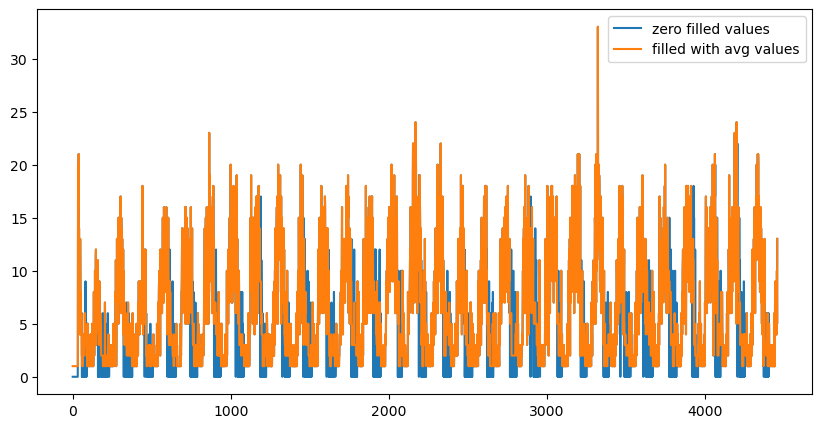

In [208]:
# Smoothing vs Filling
# sample plot that shows two variations of filling missing values
# we have taken the number of pickups for cluster region 2
plt.figure(figsize=(10,5))
plt.plot(jan_2021_fill[4464:8920], label="zero filled values")
plt.plot(jan_2021_smooth[4464:8920], label="filled with avg values")
plt.legend()
plt.show()

In [144]:
# why we choose, these methods and which method is used for which data?

# Ans: consider we have data of some month in 2015 jan 1st, 10 _ _ _ 20, i.e there are 10 pickups that are happened in 1st 
# 10st 10min intravel, 0 pickups happened in 2nd 10mins intravel, 0 pickups happened in 3rd 10min intravel 
# and 20 pickups happened in 4th 10min intravel.
# in fill_missing method we replace these values like 10, 0, 0, 20
# where as in smoothing method we replace these values as 6,6,6,6,6, if you can check the number of pickups 
# that are happened in the first 40min are same in both cases, but if you can observe that we looking at the future values 
# wheen you are using smoothing we are looking at the future number of pickups which might cause a data leakage.

# so we use smoothing for jan 2015th data since it acts as our training data
# and we use simple fill_misssing method for 2016th data.

In [209]:
jan_2021_smooth = smoothing(jan_2021_groupby['trip_distance'].values,jan_2021_unique)
jan_2022_smooth = fill_missing(jan_2022_groupby['trip_distance'].values,jan_2022_unique)
feb_2022_smooth = fill_missing(feb_2022_groupby['trip_distance'].values,feb_2022_unique)
mar_2022_smooth = fill_missing(mar_2022_groupby['trip_distance'].values,mar_2022_unique)

In [210]:
# Making list of all the values of pickup data in every bin for a period of 3 months and storing them region-wise 
regions_cum = []

# a =[1,2,3]
# b = [2,3,4]
# a+b = [1, 2, 3, 2, 3, 4]

# number of 10min indices for jan 2015= 24*31*60/10 = 4464
# number of 10min indices for jan 2016 = 24*31*60/10 = 4464
# number of 10min indices for feb 2016 = 24*29*60/10 = 4176
# number of 10min indices for march 2016 = 24*31*60/10 = 4464
# regions_cum: it will contain 40 lists, each list will contain 4464+4176+4464 values which represents the number of pickups 
# that are happened for three months in 2016 data

for i in range(0,50):
    regions_cum.append(jan_2022_smooth[4464*i:4464*(i+1)]+feb_2022_smooth[4176*i:4176*(i+1)]+mar_2022_smooth[4464*i:4464*(i+1)])

print(len(regions_cum))

print(len(regions_cum[0]))



50
13104


## Time series and Fourier Transforms

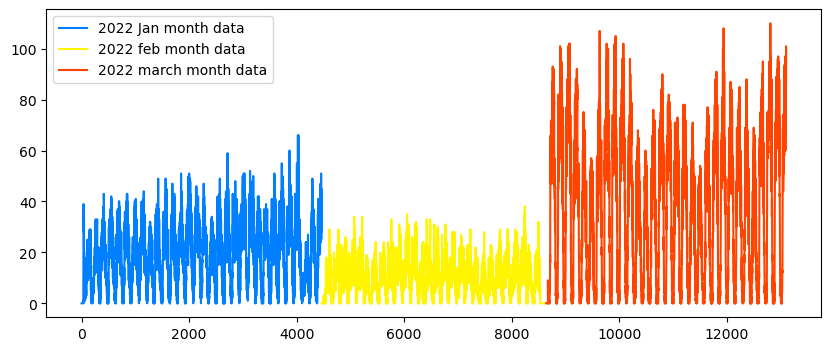

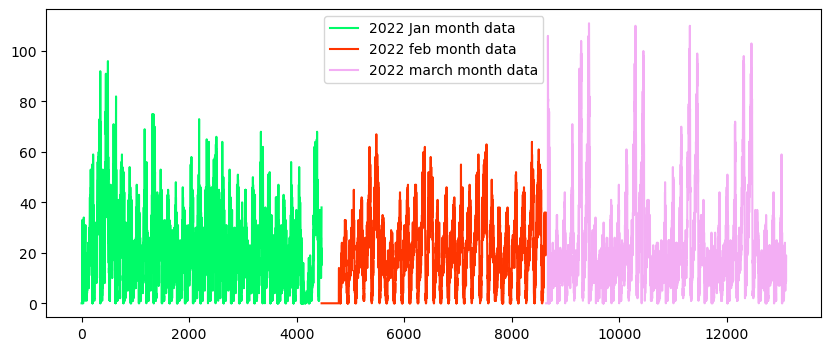

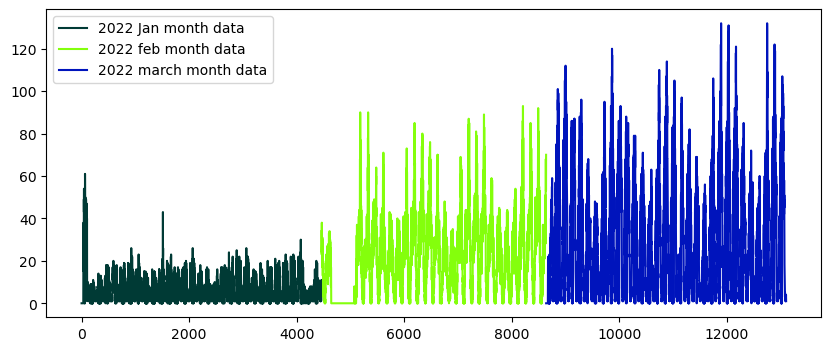

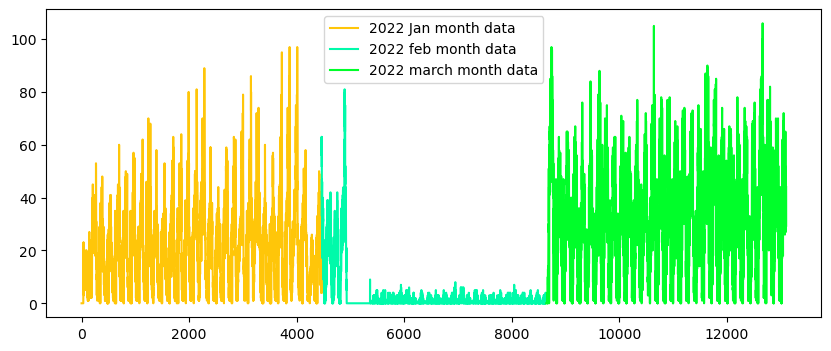

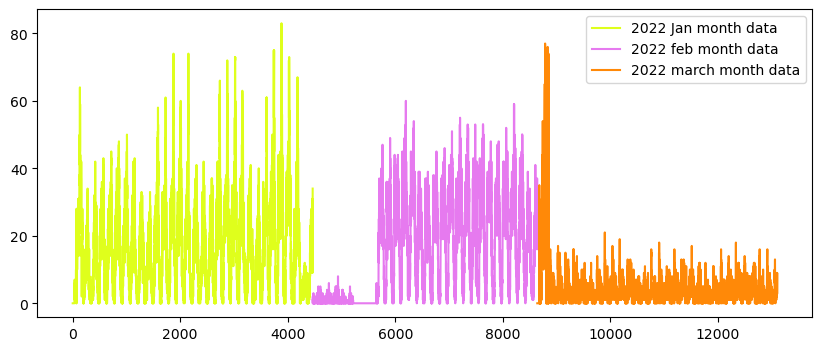

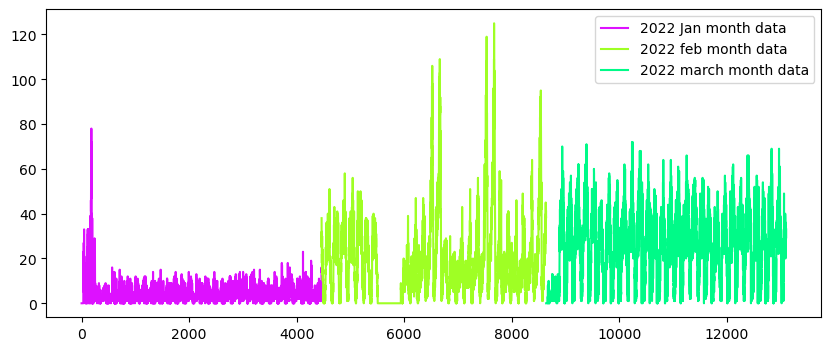

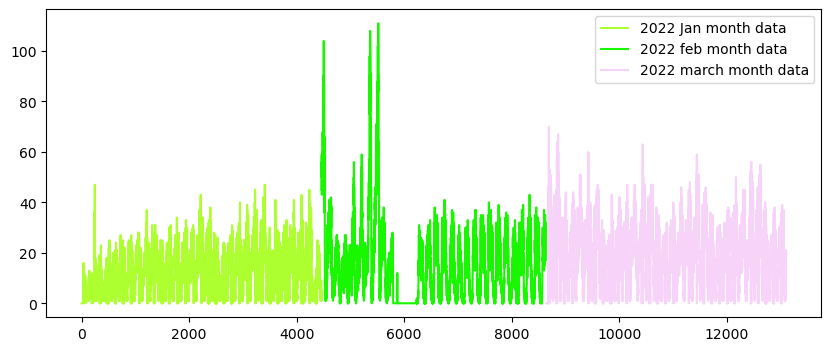

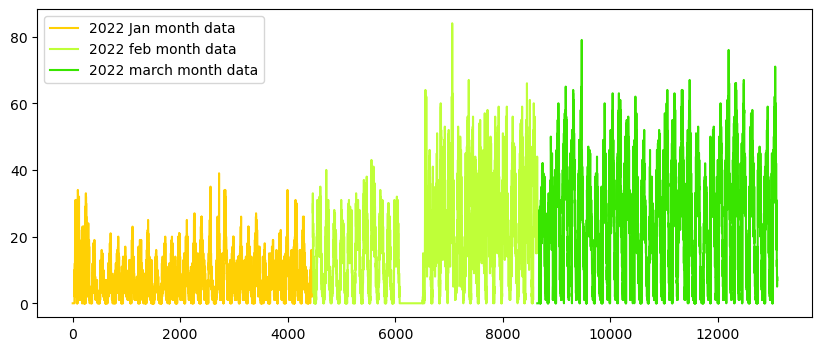

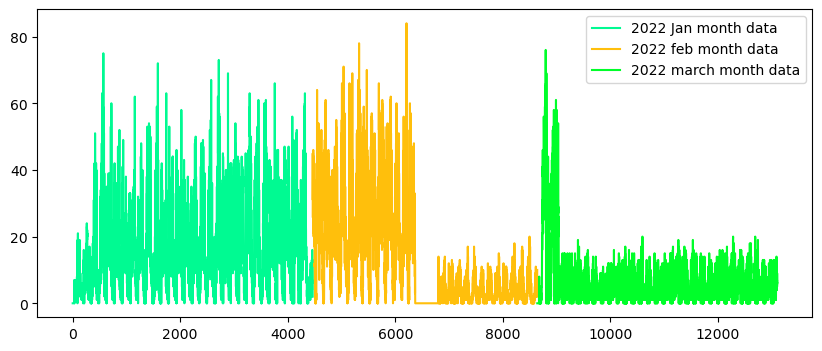

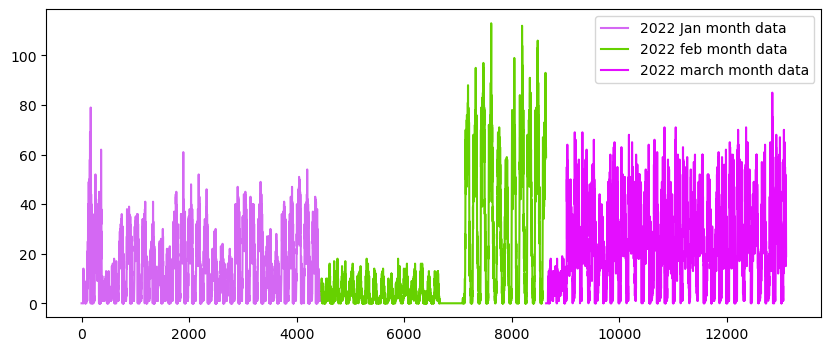

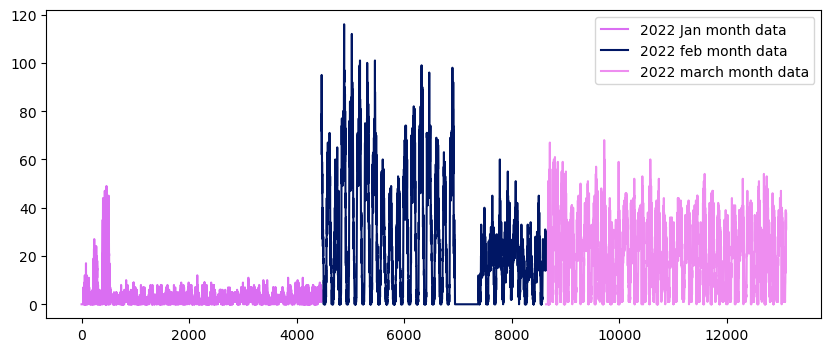

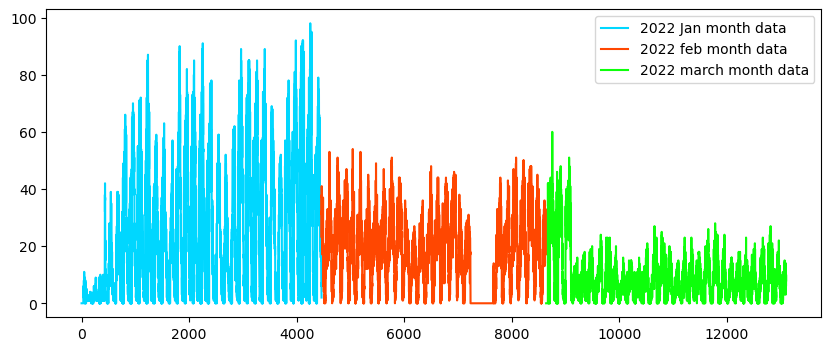

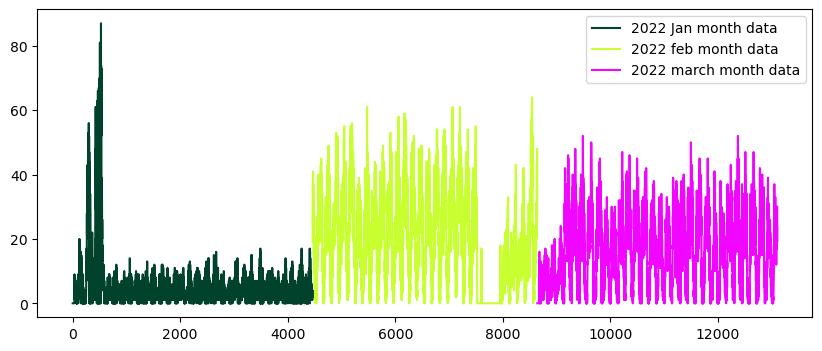

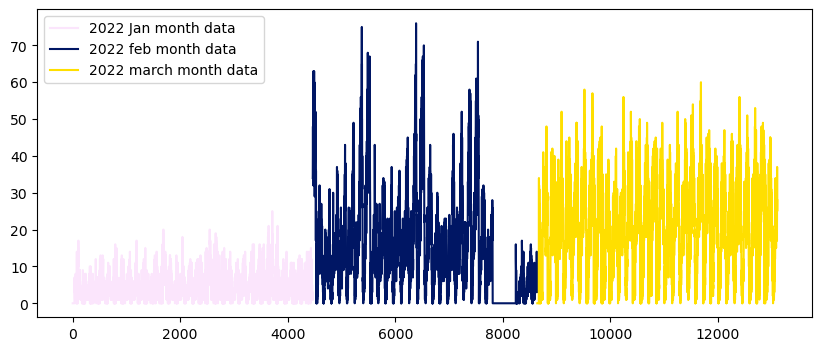

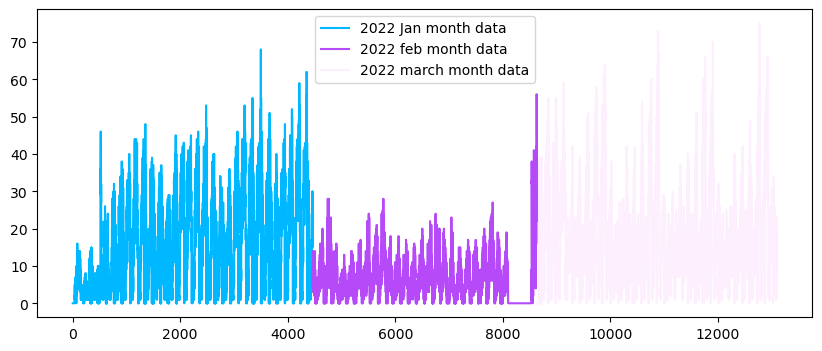

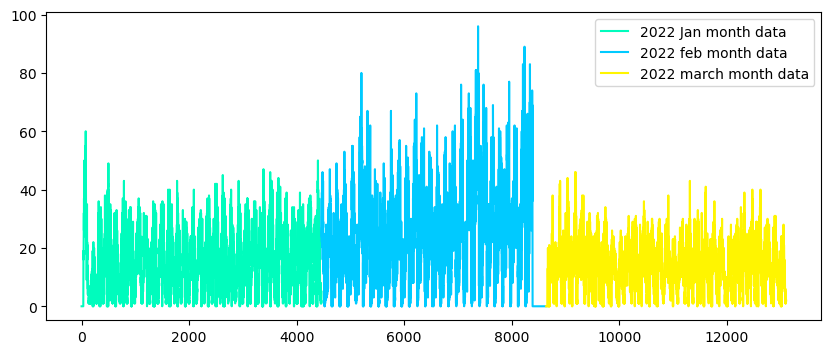

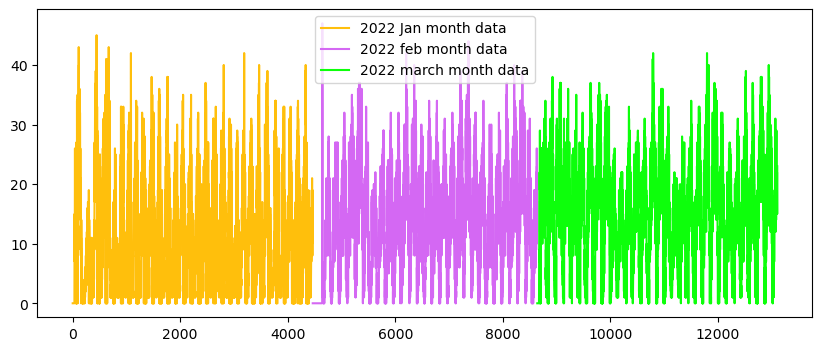

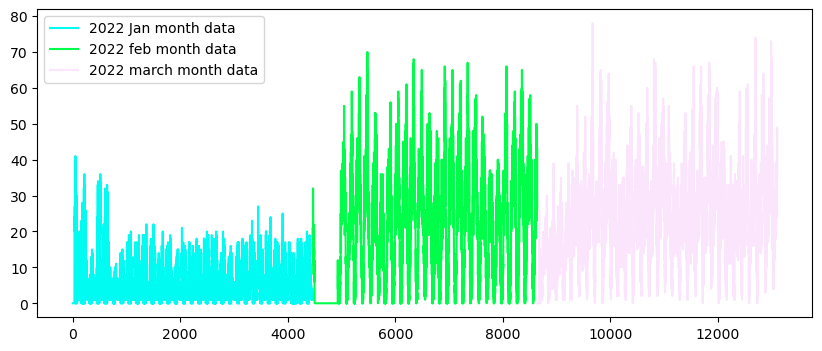

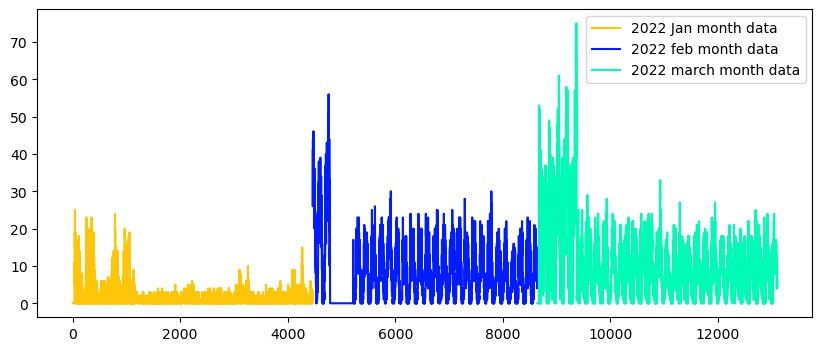

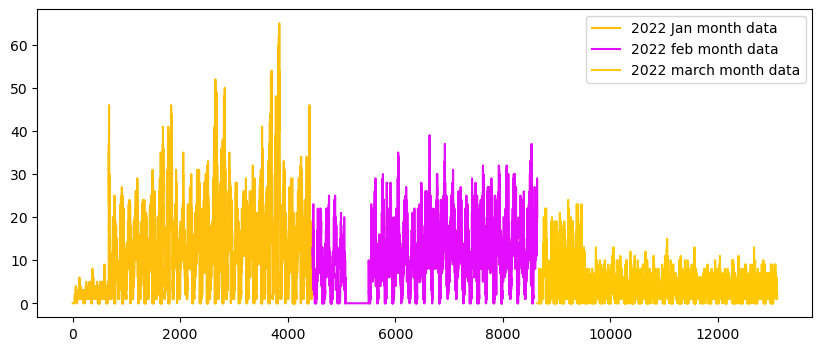

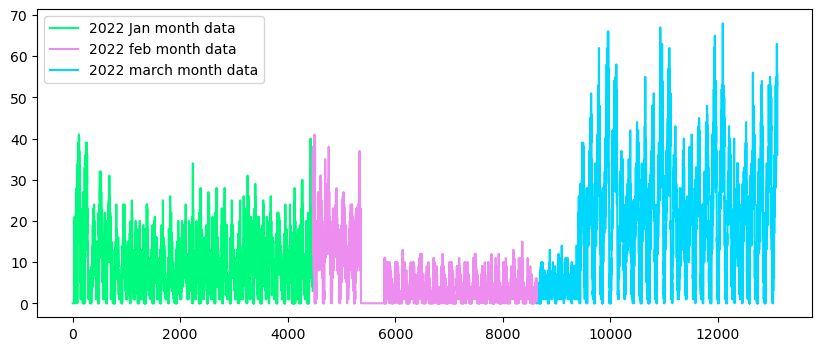

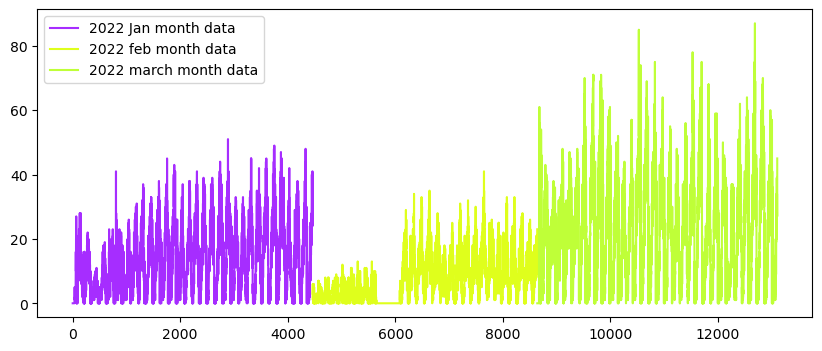

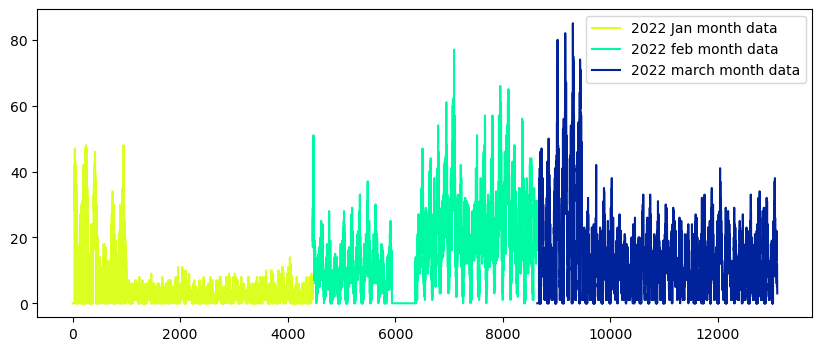

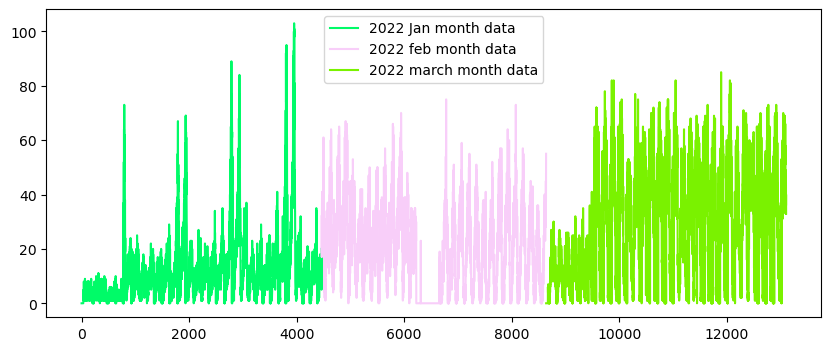

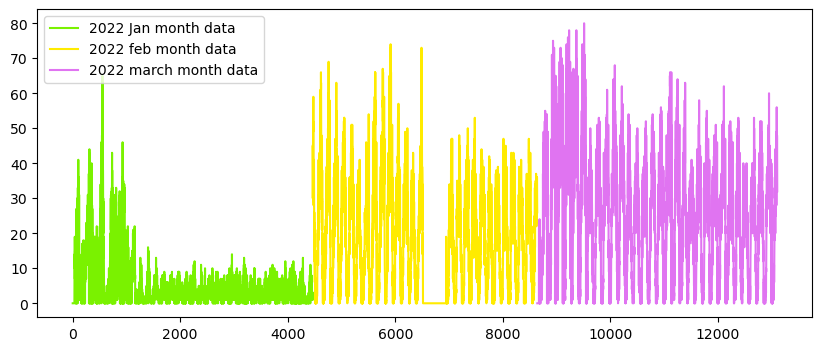

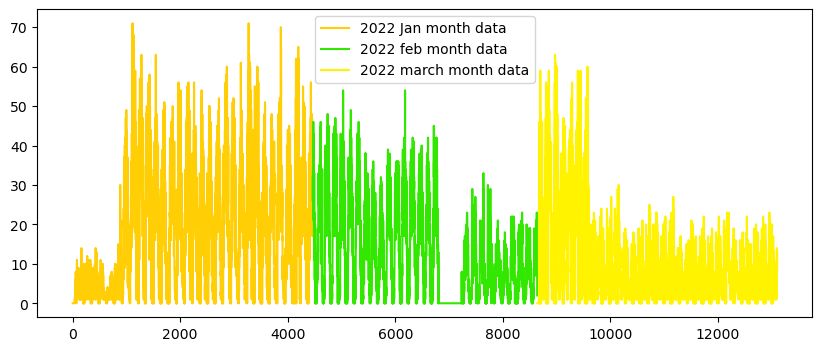

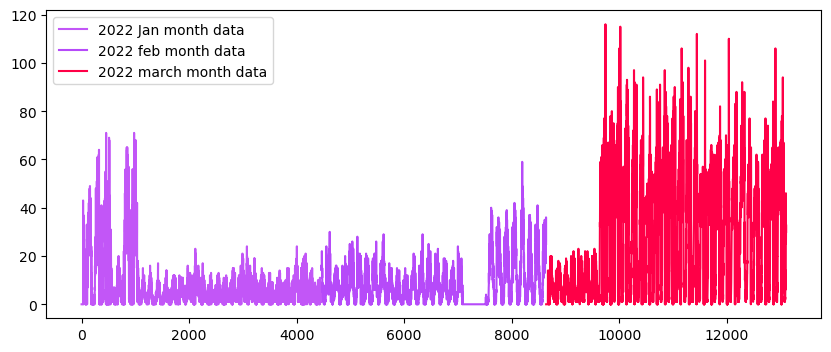

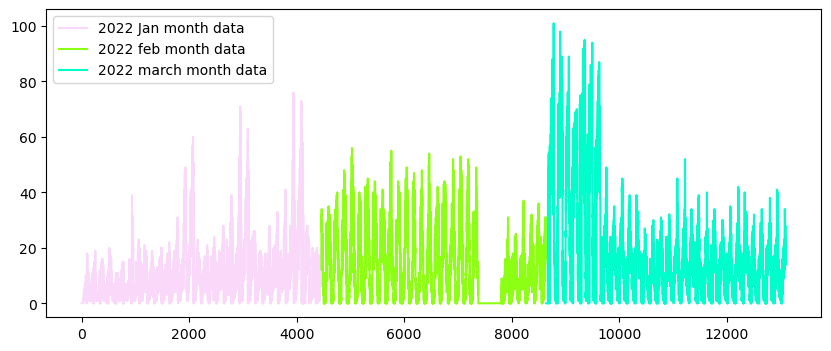

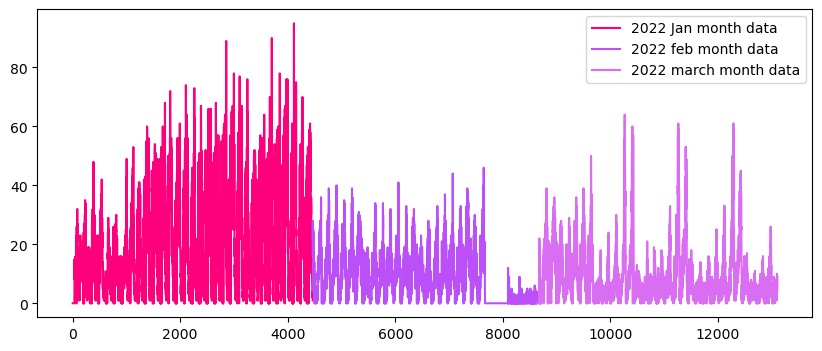

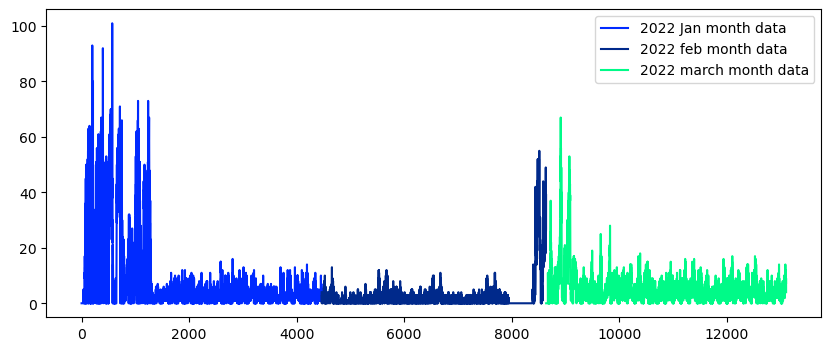

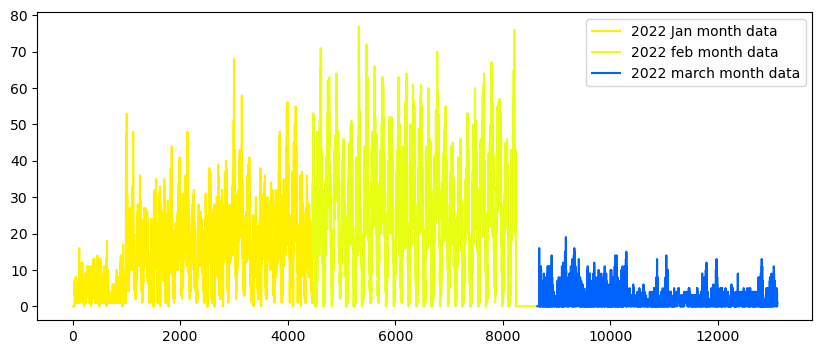

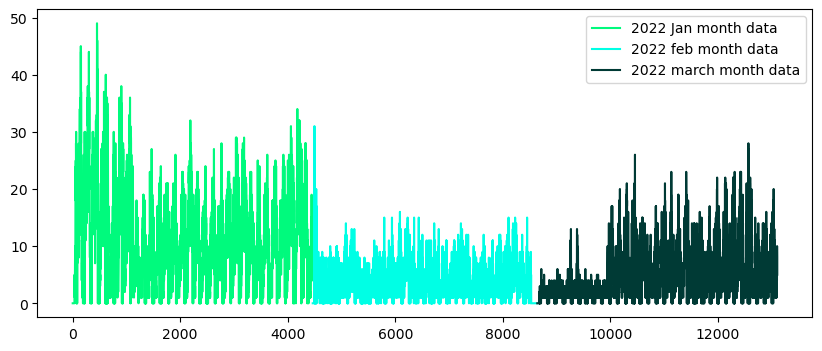

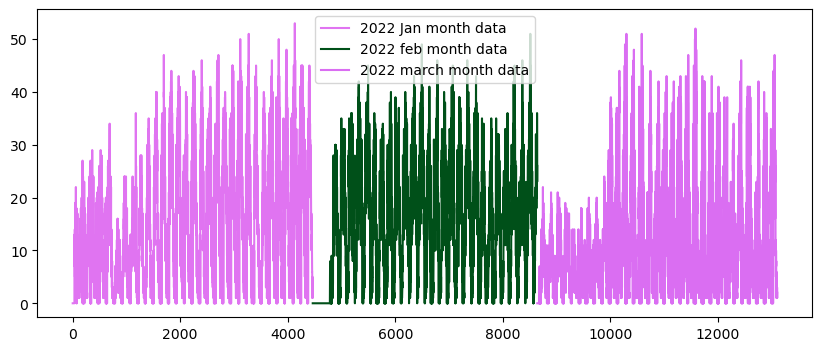

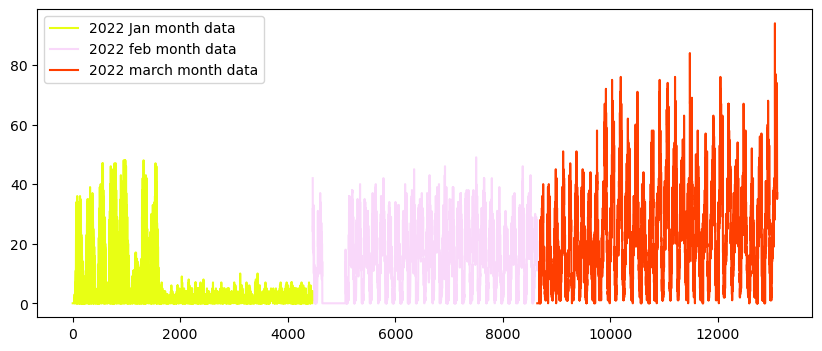

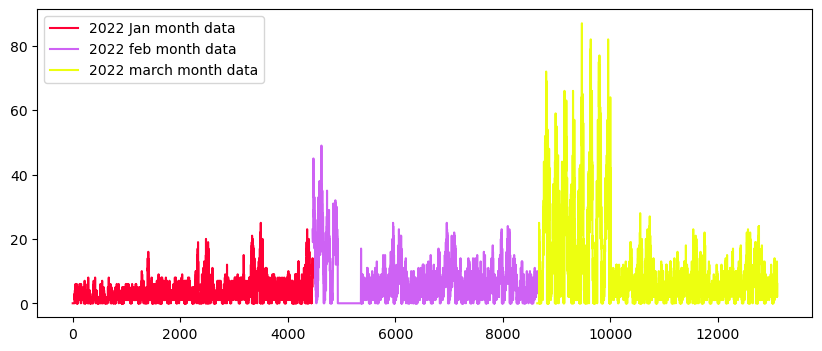

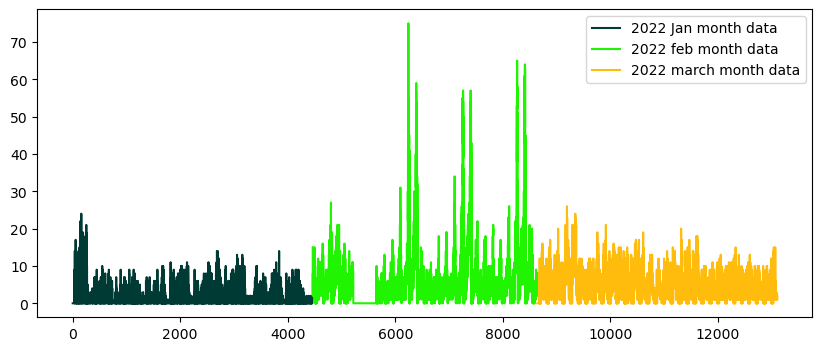

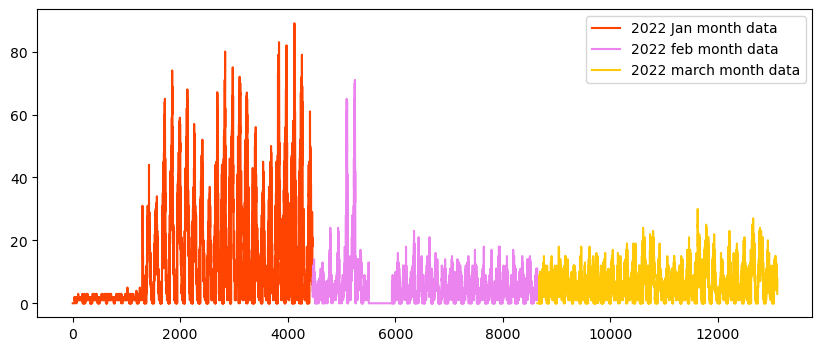

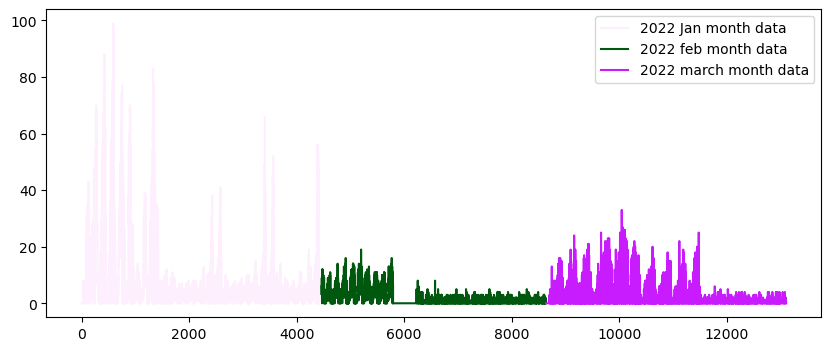

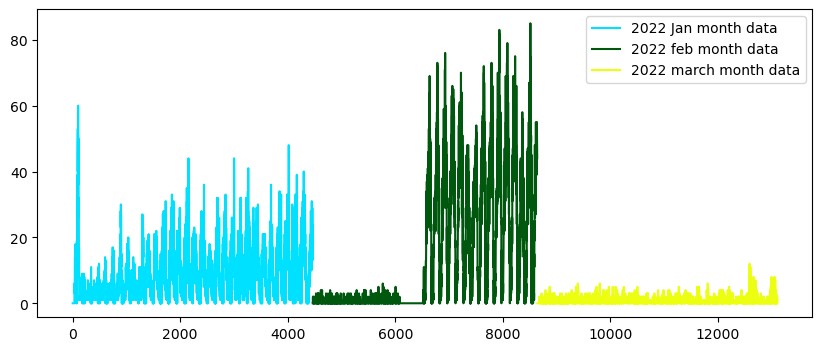

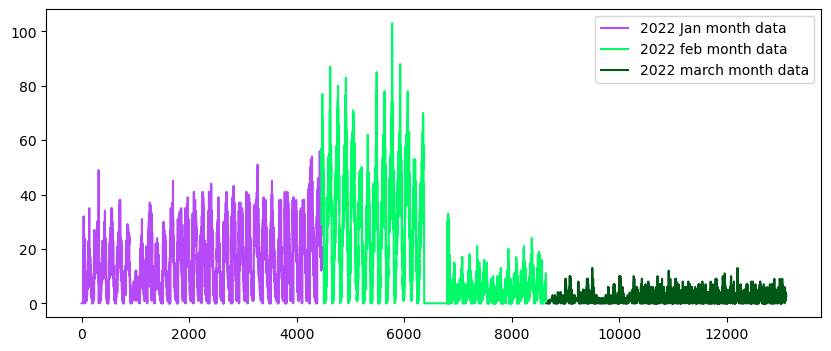

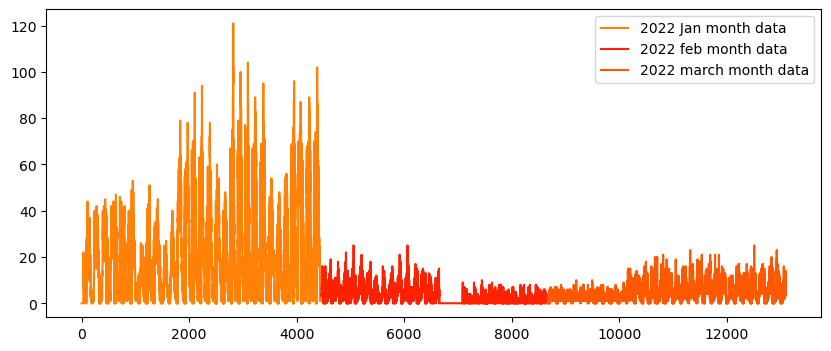

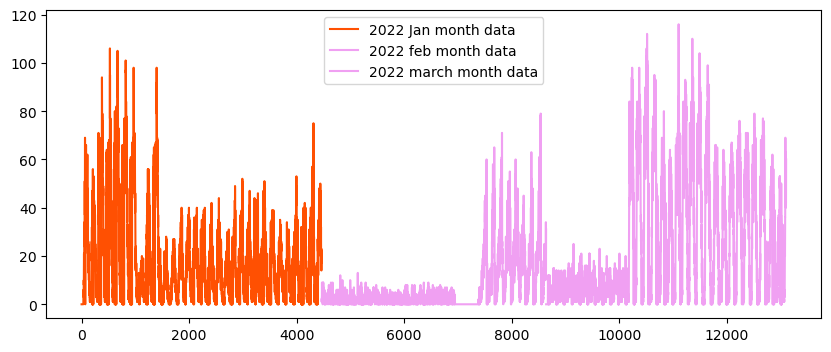

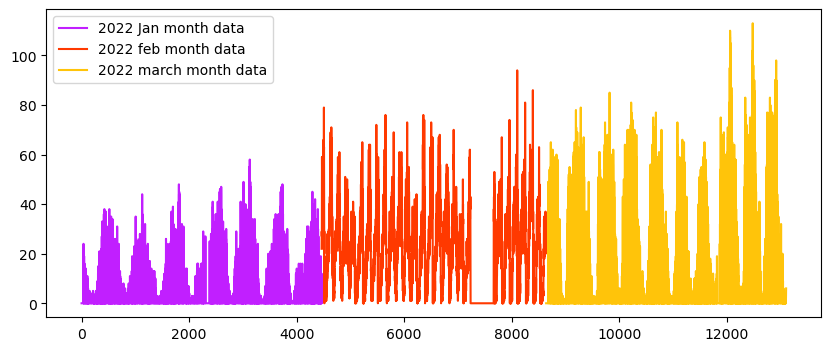

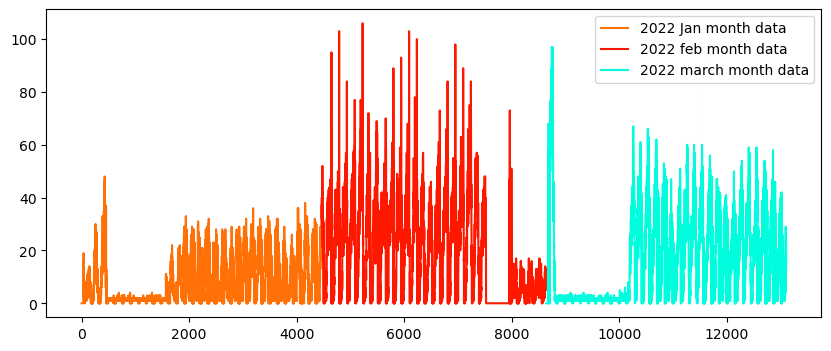

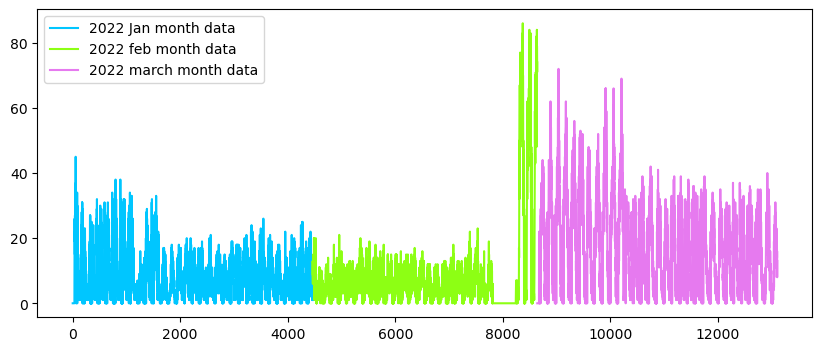

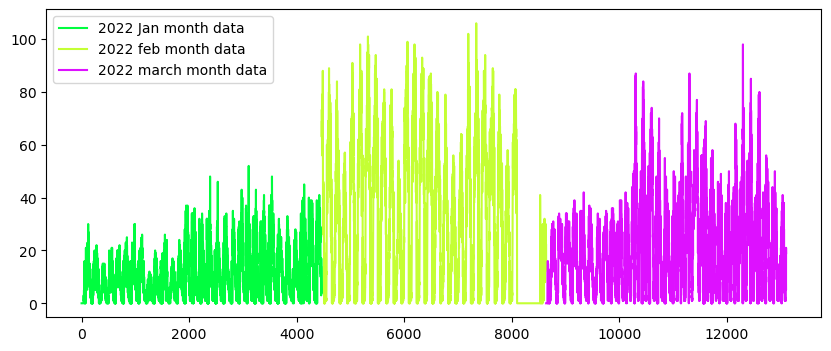

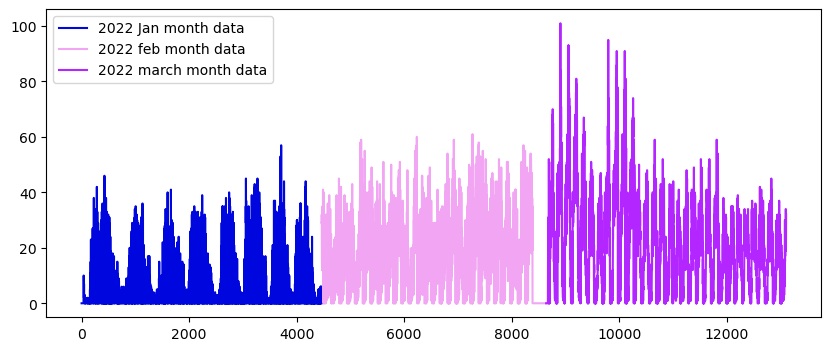

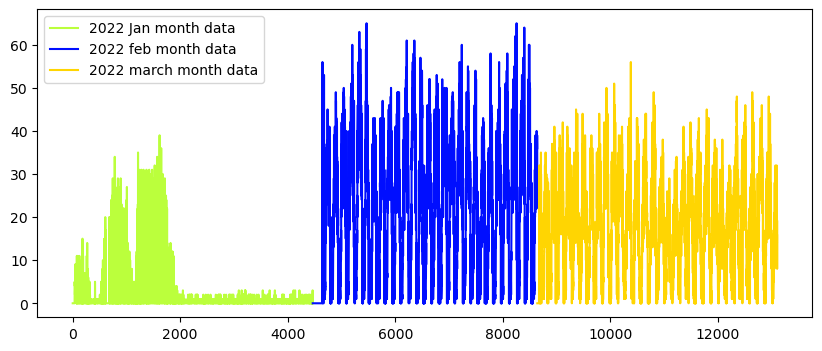

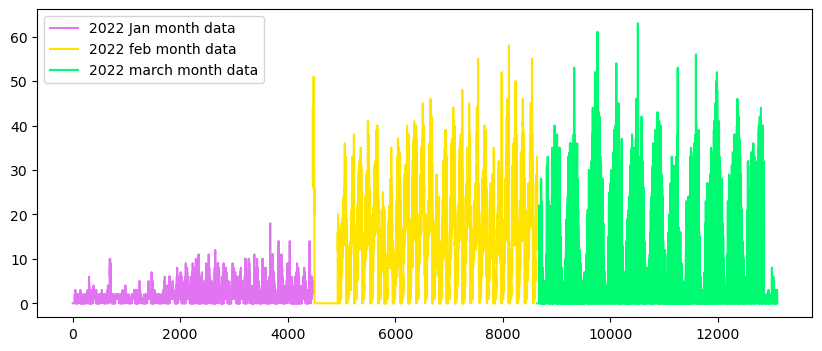

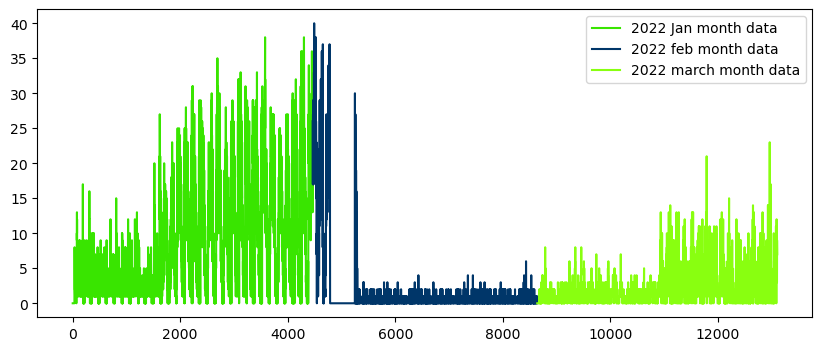

In [211]:
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())
first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))
for i in range(50):
    plt.figure(figsize=(10,4))
    plt.plot(first_x,regions_cum[i][:4464], color=uniqueish_color(), label='2022 Jan month data')
    plt.plot(second_x,regions_cum[i][4464:8640], color=uniqueish_color(), label='2022 feb month data')
    plt.plot(third_x,regions_cum[i][8640:], color=uniqueish_color(), label='2022 march month data')
    plt.legend()
    plt.show()

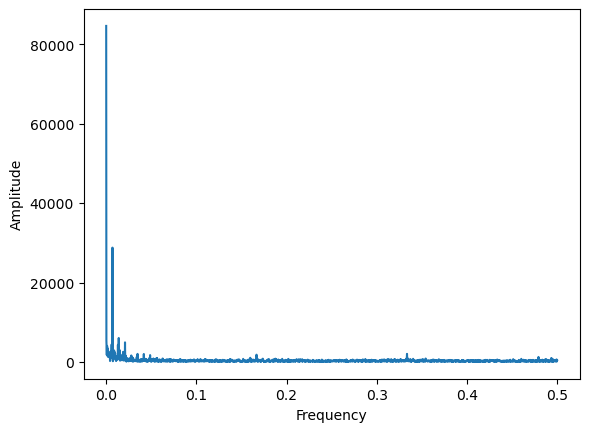

In [212]:
# getting peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
# read more about fft function : https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
Y    = np.fft.fft(np.array(jan_2022_smooth)[0:4460])
# read more about the fftfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html  
freq = np.fft.fftfreq(4460, 1)
n = len(freq)
plt.figure()
plt.plot( freq[:int(n/2)], np.abs(Y)[:int(n/2)] )
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.show()

In [215]:
#Preparing the Dataframe only with x(i) values as jan-2021 data and y(i) values as jan-2022
ratios_jan = pd.DataFrame()
ratios_jan['Given']=jan_2021_fill
ratios_jan['2022']=jan_2022_smooth
ratios_jan['Ratios']=ratios_jan['2022']*1.0/ratios_jan['Given']*1.0

In [216]:
ratios_jan = ratios_jan[ratios_jan['Given'] > 0]

In [217]:
ratios_jan.head()

Given  2022    Ratios
33      4     9  2.250000
34     14    20  1.428571
35     12    16  1.333333
36     13    27  2.076923
37     15    39  2.600000

## Modelling: Baseline Models

Now we get into modelling in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using Previous known values of the 2016 data itself to predict the future values

### Simple Moving Averages
The First Model used is the Moving Averages Model which uses the previous n values in order to predict the next value <br> 

Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$

In [218]:
def moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'SMA'+str(n)
    ratios[lab] = ratios['Ratios'].rolling(n).mean()
    ratios['Pred'] = ratios[lab] * ratios['2022']
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    mse = ratios['se'].sum()/len(ratios)
    print(ratios.head())
    #Plotting the moving averages
    
    return mse

    Given  2022    Ratios      SMA5        Pred           se
37     15    39  2.600000  1.937766   75.572857  1337.573880
38     15    31  2.066667  1.901099   58.934066   780.312040
39      7    28  4.000000  2.415385   67.630769  1570.597870
40      9    29  3.222222  2.793162   81.001709  2704.177781
41      8    33  4.125000  3.202778  105.691667  5284.078403
111928.60989075346
334.5573342354842
    Given  2022    Ratios     SMA10        Pred           se
42      5    33  6.600000  2.970272   98.018965  4227.465836
43      8    35  4.375000  3.182772  111.397009  5836.502915
44      5    19  3.800000  3.419915   64.978376  2114.011066
45     11    17  1.545455  3.441127   58.499153  1722.179705
46      7    17  2.428571  3.476291   59.096955  1772.153643
98672.62757524024
314.1219947333205
     Given  2022    Ratios    SMA100       Pred          se
138     16    16  1.000000  1.815756  29.052099  170.357281
139     14    15  1.071429  1.803970  27.059557  145.432911
140     16    2

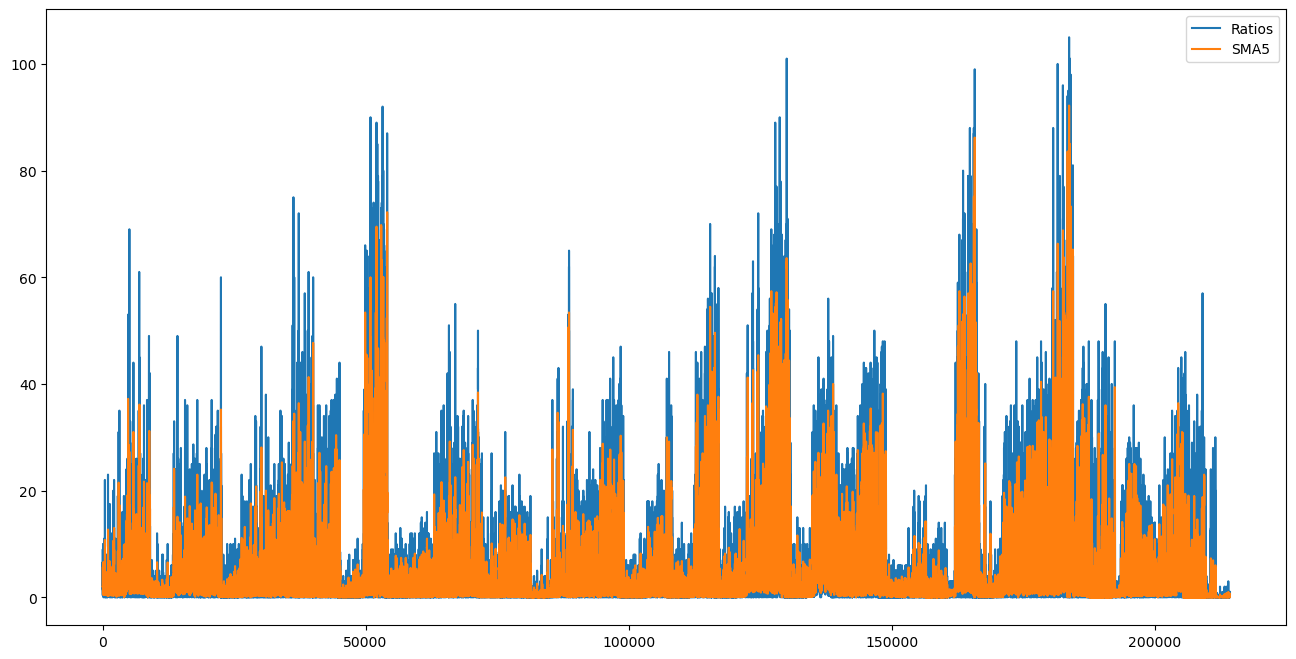

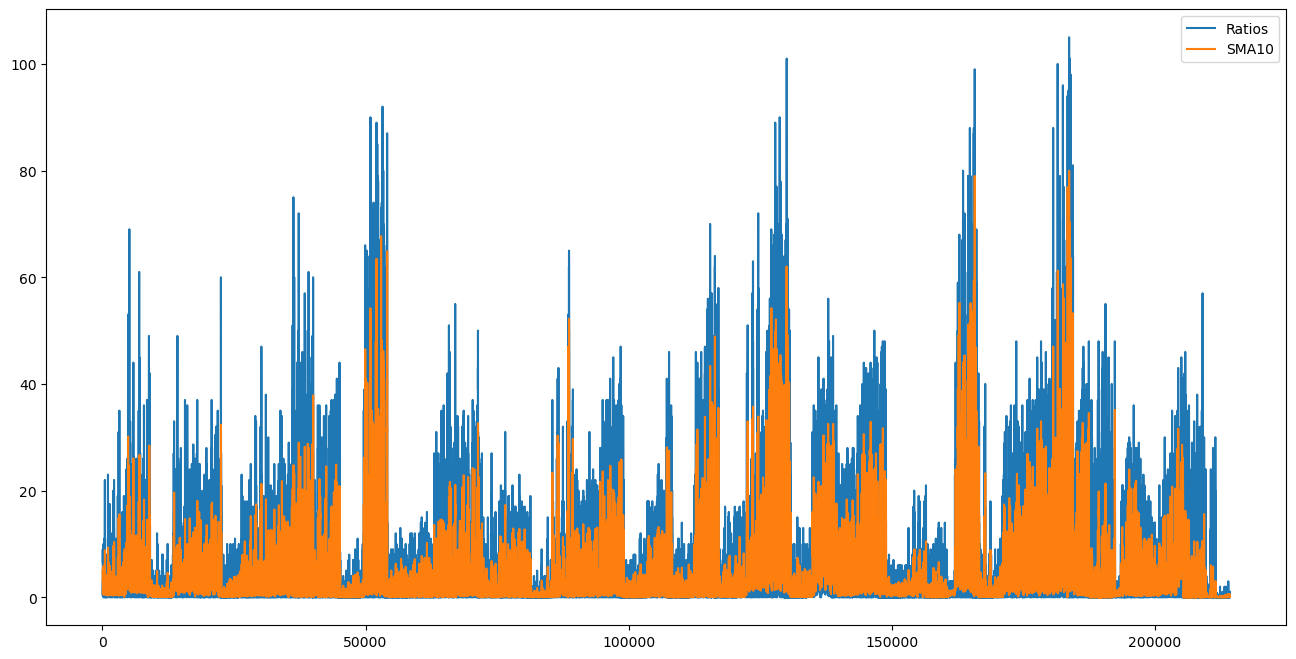

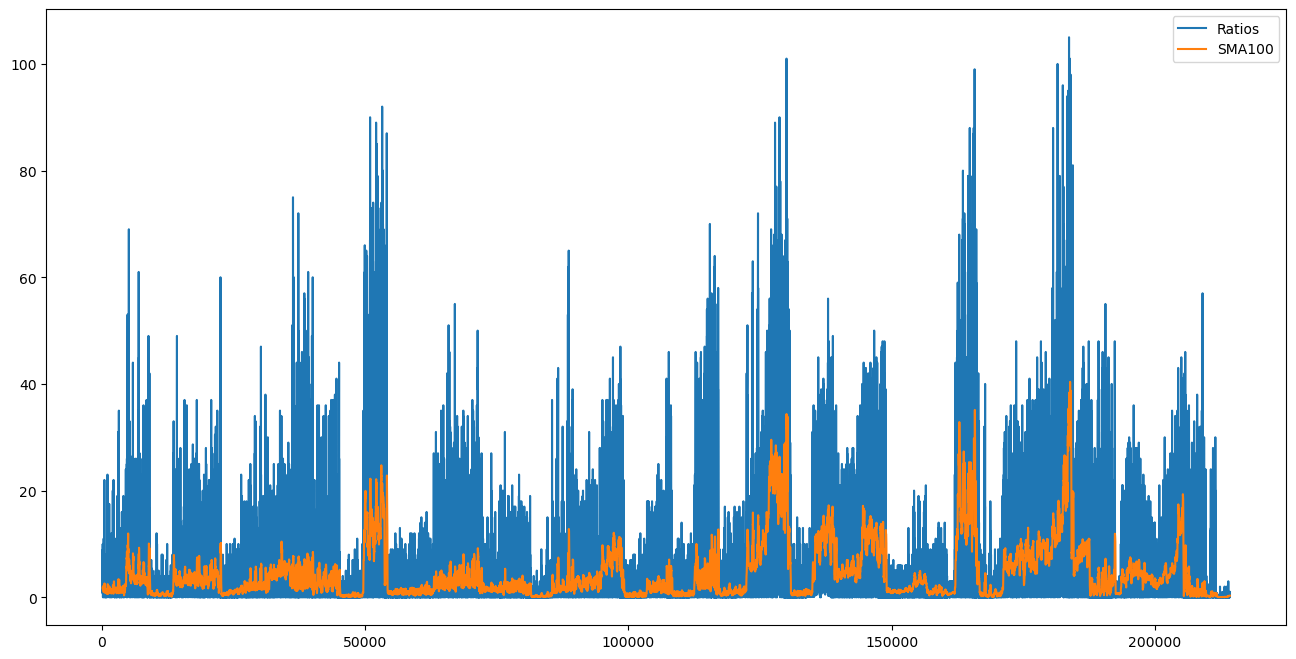

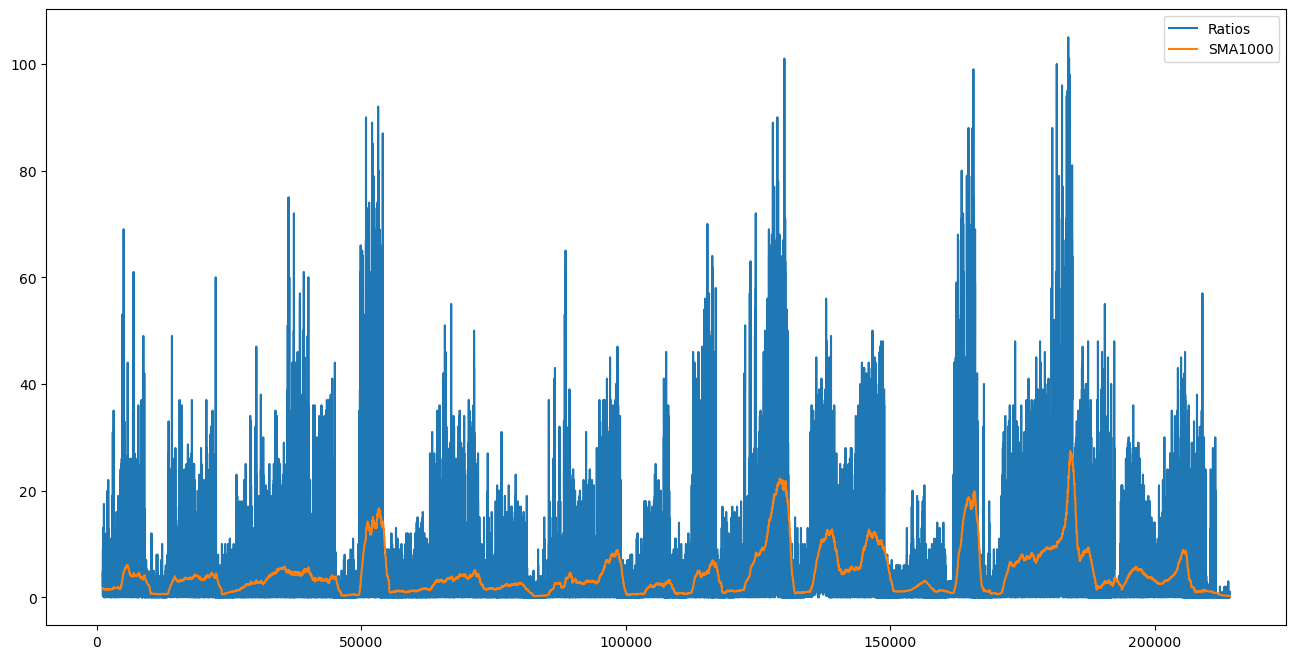

In [220]:
mse = moving_averages_ratios(ratios_jan,5)
print(mse)
print((mse)**(0.5))

mse = moving_averages_ratios(ratios_jan,10)
print(mse)
print((mse)**(0.5))

mse = moving_averages_ratios(ratios_jan,100)
print(mse)
print((mse)**(0.5))

mse = moving_averages_ratios(ratios_jan,1000)
print(mse)
print((mse)**(0.5))

In [221]:
#Choosing 5 as the most suitable value

In [222]:
#We can apply gradient descent to tune the hyper parameter(n), should we or too complex?

Next we use the Moving averages of the 2016  values itself to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$

In [223]:
def moving_averages_prev(r, n):
    ratios = r.copy()
    ratios['Pred'] = ratios['2022'].rolling(n).mean()
    ratios['se'] = ((ratios['Pred'] - ratios['2022'])**2)
    ratios.dropna(inplace=True)
    ratios[['2022', 'Pred']].plot(label='Predicted Values',figsize=(16, 8))
    mse = ratios['se'].sum()/len(ratios)
    print(ratios.head())
    #Plotting the moving averages
    
    return mse

    Given  2022    Ratios  Pred     se
34     14    20  1.428571  14.5  30.25
35     12    16  1.333333  18.0   4.00
36     13    27  2.076923  21.5  30.25
37     15    39  2.600000  33.0  36.00
38     15    31  2.066667  35.0  16.00
12.938497151694301
    Given  2022    Ratios  Pred      se
37     15    39  2.600000  22.2  282.24
38     15    31  2.066667  26.6   19.36
39      7    28  4.000000  28.2    0.04
40      9    29  3.222222  30.8    3.24
41      8    33  4.125000  32.0    1.00
25.722760006786473
    Given  2022    Ratios  Pred      se
42      5    33  6.600000  26.5   42.25
43      8    35  4.375000  29.1   34.81
44      5    19  3.800000  29.0  100.00
45     11    17  1.545455  29.1  146.41
46      7    17  2.428571  28.1  123.21
37.75491350226115
     Given  2022    Ratios   Pred       se
138     16    16  1.000000  13.85   4.6225
139     14    15  1.071429  13.91   1.1881
140     16    22  1.375000  13.93  65.1249
141     15    23  1.533333  14.00  81.0000
142     18    2

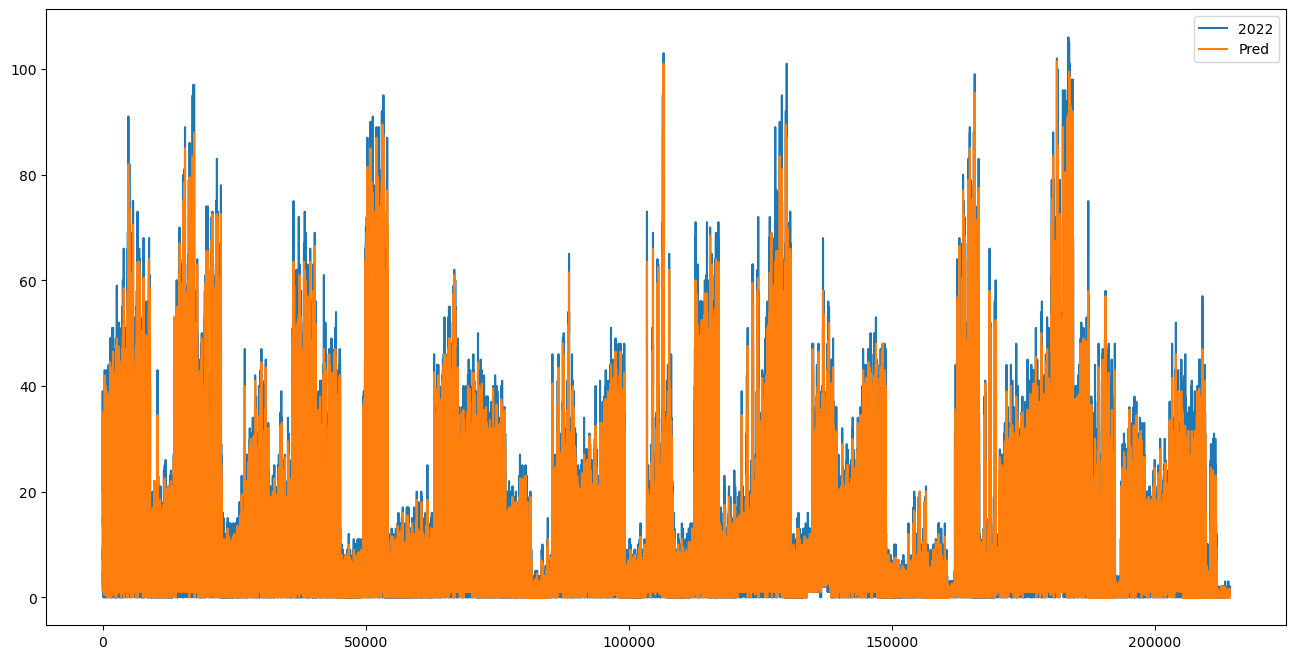

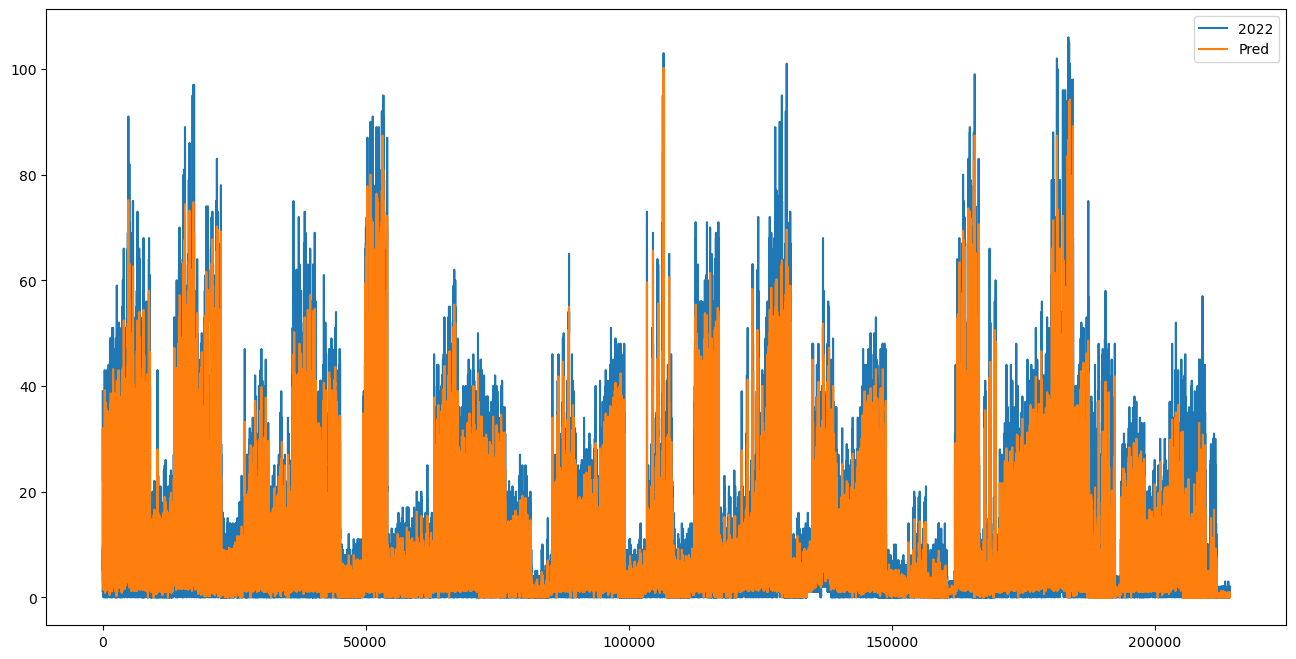

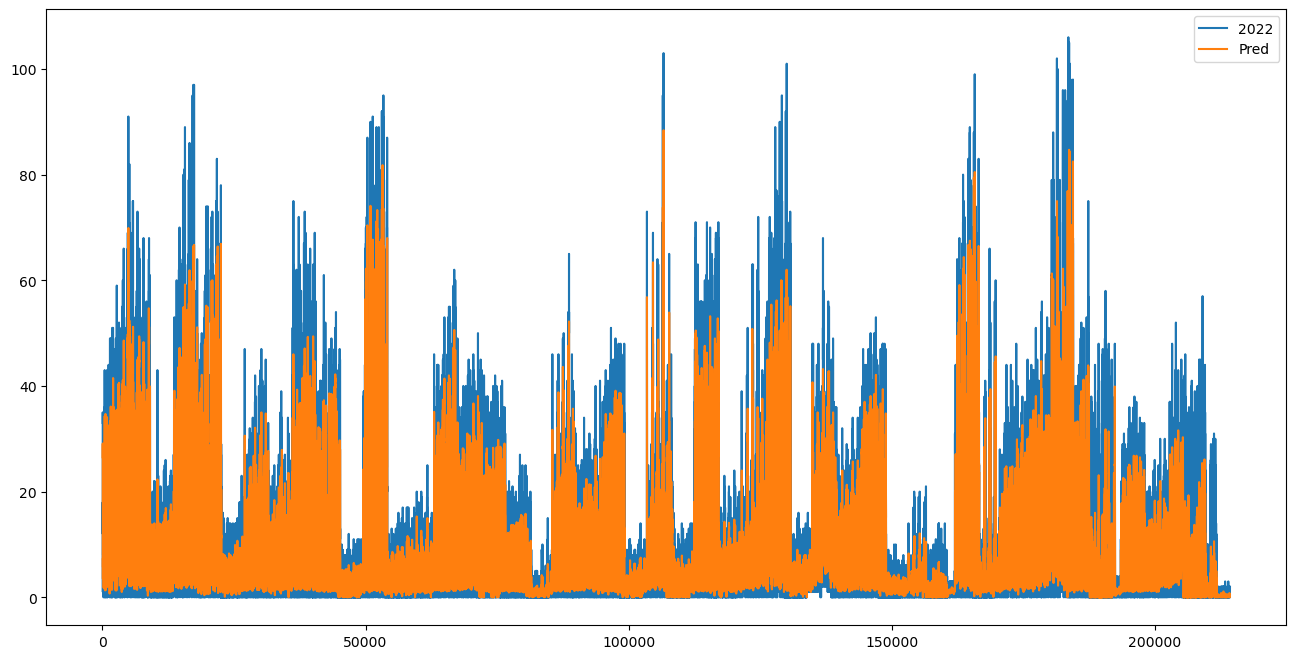

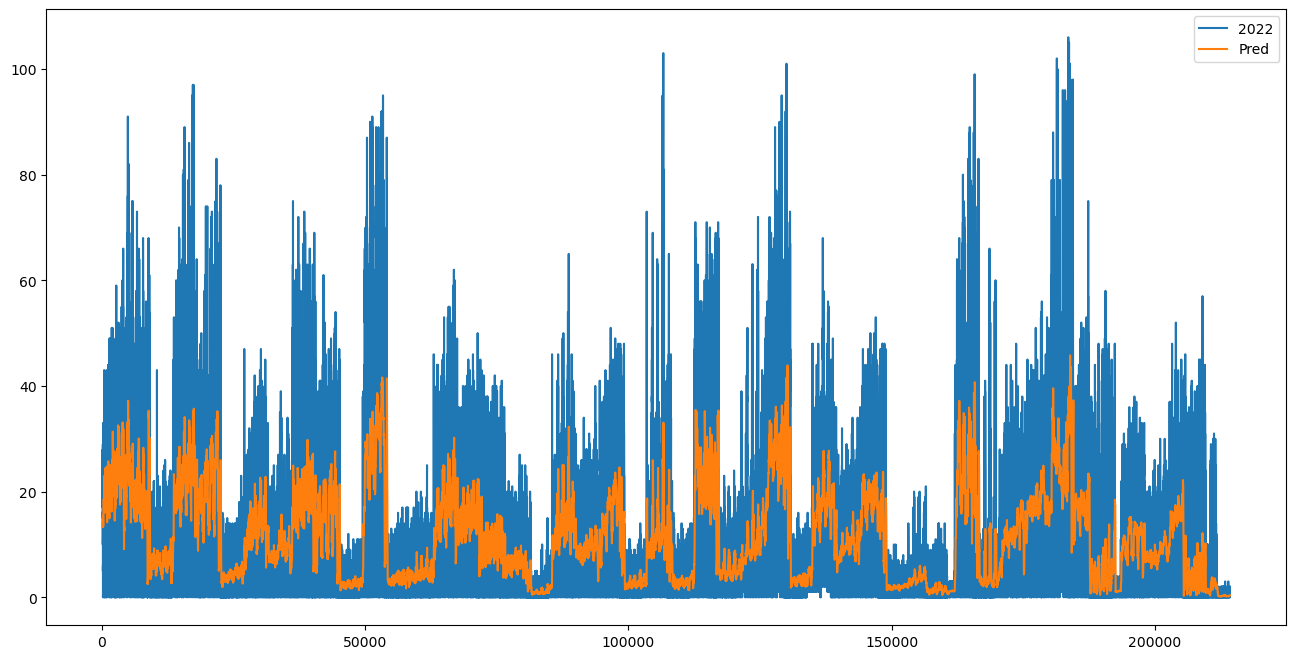

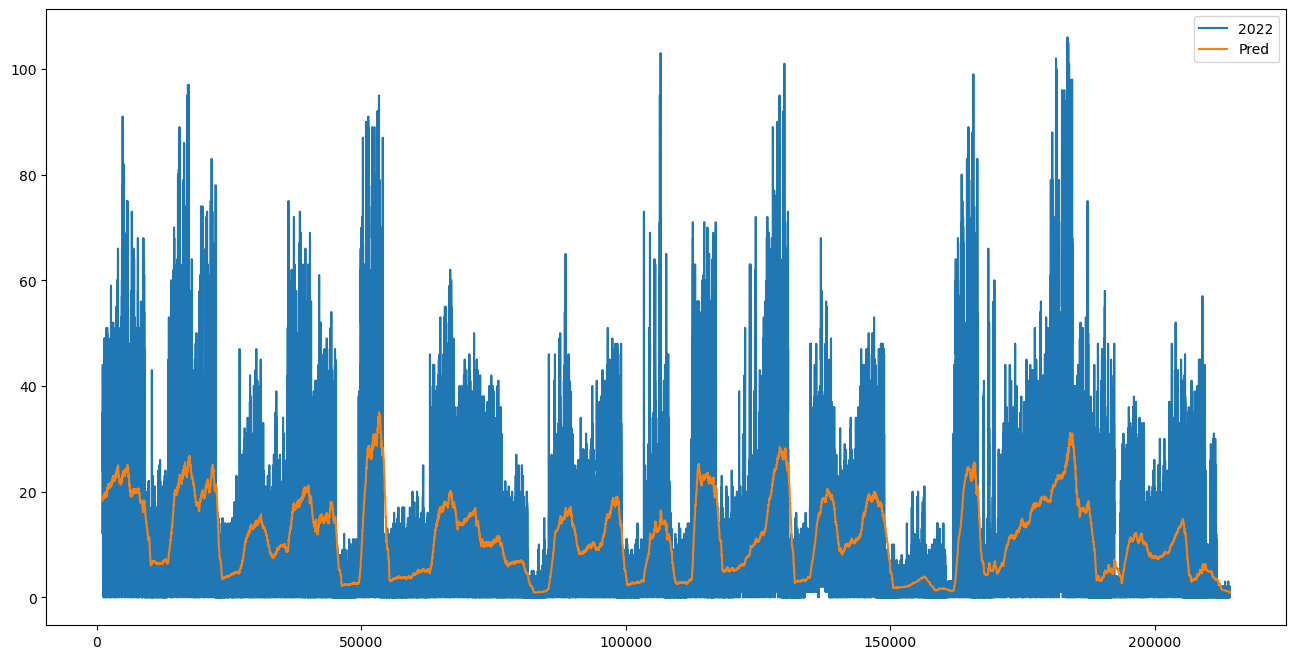

In [224]:
print(moving_averages_prev(ratios_jan, 2))
print(moving_averages_prev(ratios_jan, 5))
print(moving_averages_prev(ratios_jan, 10))
print(moving_averages_prev(ratios_jan, 100))
print(moving_averages_prev(ratios_jan, 1000))

In [225]:
#Moving averages for 2022 values itself is much more accurate than with the ratios

## Exponential Moving Averages


Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones but we still do not know which is the correct weighting scheme as there are infinetly many possibilities in which we can assign weights in a non-increasing order and tune the the hyperparameter window-size. To simplify this process we use Exponential Moving Averages which is a more logical way towards assigning weights and at the same time also using an optimal window-size.

In exponential moving averages we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.<br>
For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is~$\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. Also the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$ ,where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.

$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [226]:
def exponential_moving_averages_ratios(r, n):
    ratios = r.copy()
    lab = 'EWMA' + str(n)
    ratios[lab] = ratios['Ratios'].ewm(span=n).mean()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'] * ratios[lab]
    ratios[['Ratios', lab]].plot(label='Ratios',figsize=(16, 8))
    ratios['se'] = (ratios['2022'] - ratios['Pred'])**2
    print(ratios.head())
    mse = ratios['se'].sum()/len(ratios)
    return mse

    Given  2022    Ratios     EWMA5       Pred           se
33      4     9  2.250000  2.250000  20.250000   126.562500
34     14    20  1.428571  1.757143  35.142857   229.306122
35     12    16  1.333333  1.556391  24.902256    79.250155
36     13    27  2.076923  1.772612  47.860524   435.161465
37     15    39  2.600000  2.090235  81.519160  1807.879006
113217.71996974932
    Given  2022    Ratios    EWMA10       Pred           se
33      4     9  2.250000  2.250000  20.250000   126.562500
34     14    20  1.428571  1.798214  35.964286   254.858418
35     12    16  1.333333  1.611335  25.781364    95.675076
36     13    27  2.076923  1.764726  47.647593   426.323115
37     15    39  2.600000  2.004510  78.175899  1534.751035
98403.96522277014
    Given  2022    Ratios    EWMA20       Pred           se
33      4     9  2.250000  2.250000  20.250000   126.562500
34     14    20  1.428571  1.818750  36.375000   268.140625
35     12    16  1.333333  1.640508  26.248127   105.024098
36 

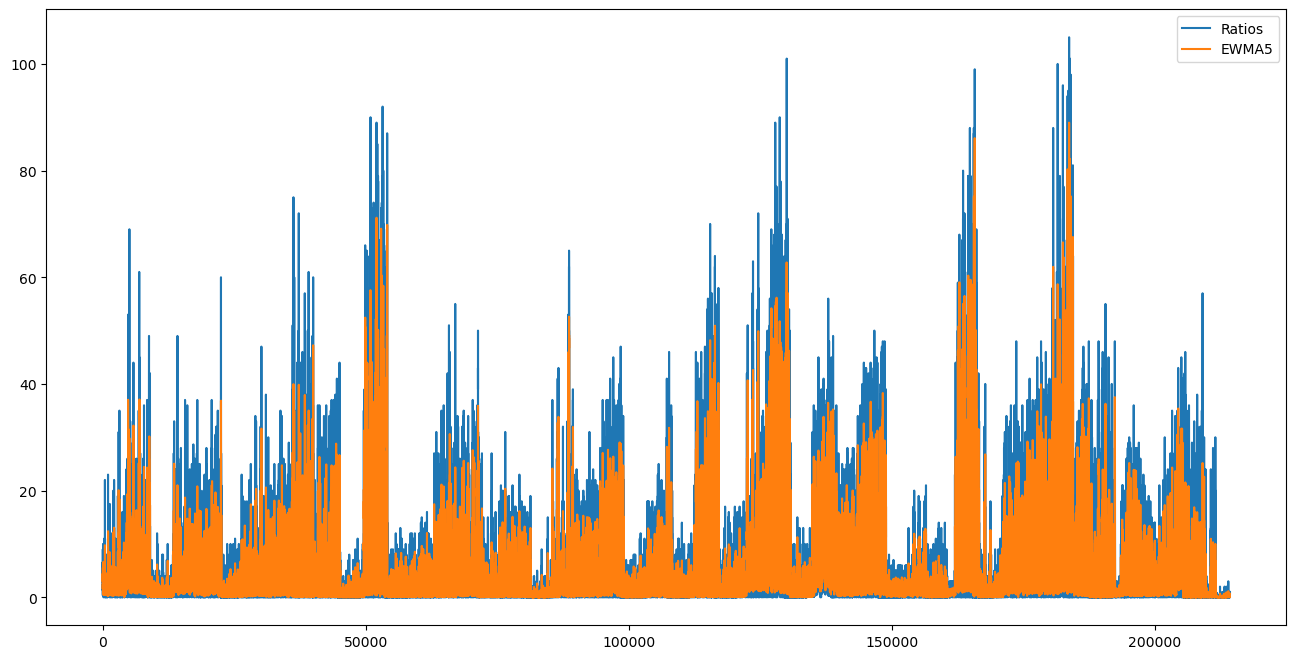

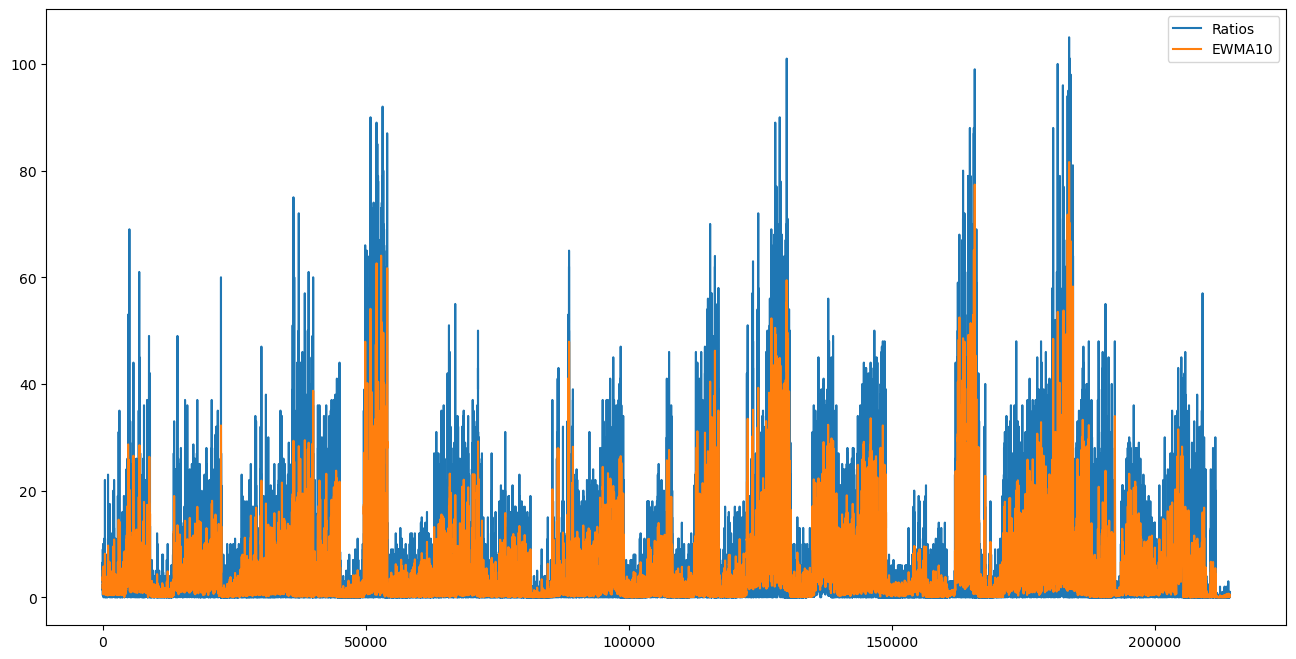

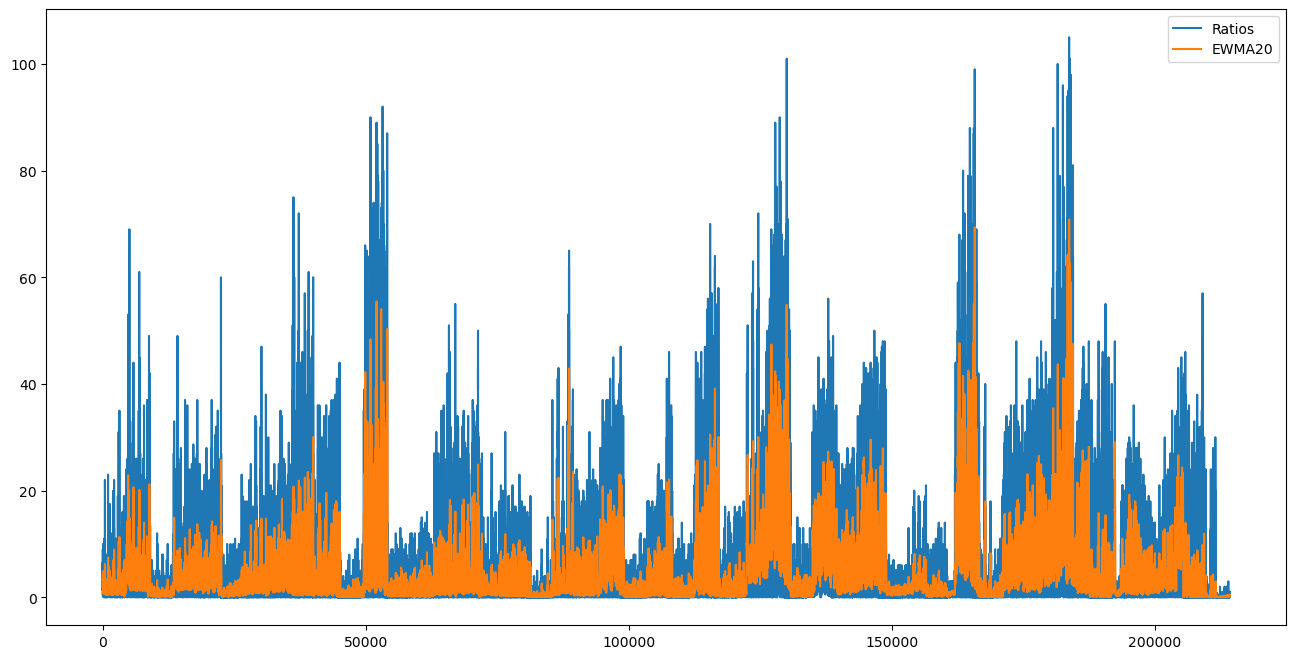

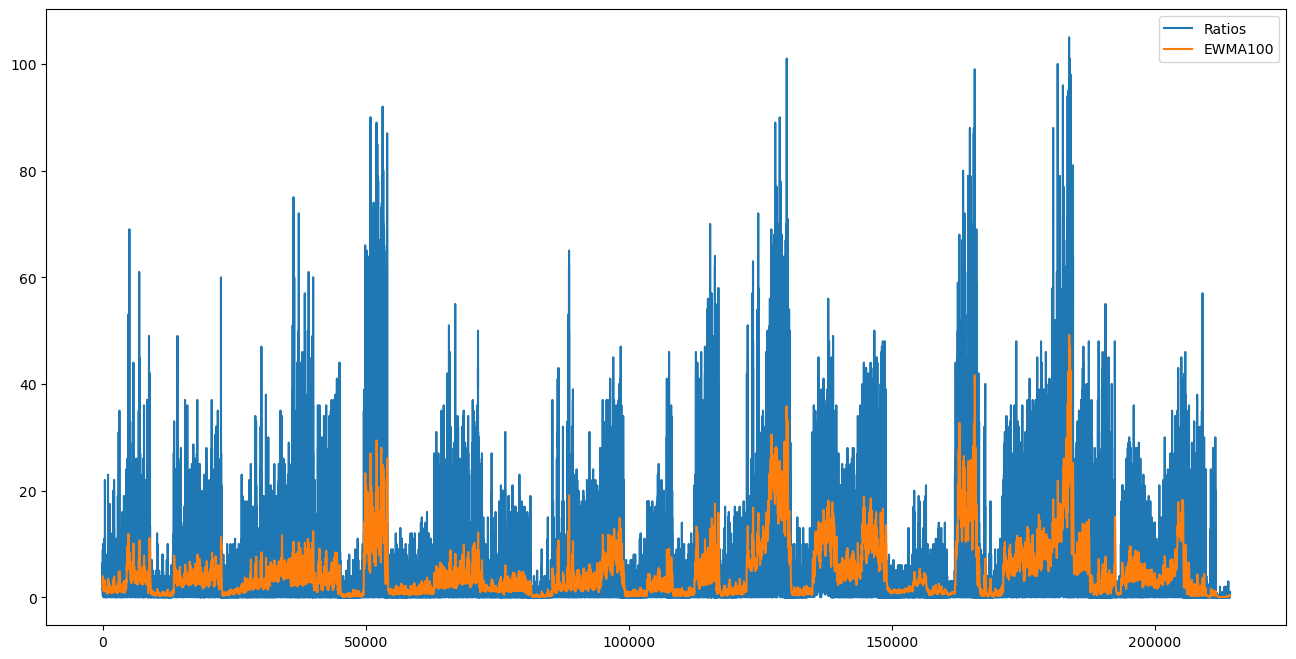

In [227]:
print(exponential_moving_averages_ratios(ratios_jan, 5))
print(exponential_moving_averages_ratios(ratios_jan, 10))
print(exponential_moving_averages_ratios(ratios_jan, 20))
print(exponential_moving_averages_ratios(ratios_jan, 100))

In [228]:
def exponential_moving_averages_prev(r, n):
    ratios = r.copy()
    ratios.dropna(inplace=True)
    ratios['Pred'] = ratios['2022'].ewm(span=n).mean()
    ratios[['2022', 'Pred']].plot(label='Predicted Values',figsize=(16, 8))
    ratios['se'] = (ratios['2022'] - ratios['Pred'])**2
    print(ratios.head())
    mse = ratios['se'].sum()/len(ratios)
    return mse

    Given  2022    Ratios       Pred          se
33      4     9  2.250000   9.000000    0.000000
34     14    20  1.428571  14.555000   29.648025
35     12    16  1.333333  15.046332    0.909483
36     13    27  2.076923  18.124993   78.765749
37     15    39  2.600000  22.468647  273.285617
92.9013760871026
    Given  2022    Ratios       Pred          se
33      4     9  2.250000   9.000000    0.000000
34     14    20  1.428571  14.610000   29.052100
35     12    16  1.333333  15.091988    0.824486
36     13    27  2.076923  18.249944   76.563480
37     15    39  2.600000  22.738459  264.437727
76.24258251644486
    Given  2022    Ratios       Pred          se
33      4     9  2.250000   9.000000    0.000000
34     14    20  1.428571  14.527500   29.948256
35     12    16  1.333333  15.023250    0.954041
36     13    27  2.076923  18.062499   79.878922
37     15    39  2.600000  22.334166  277.750025
102.45895756180197
    Given  2022    Ratios       Pred          se
33      4     9

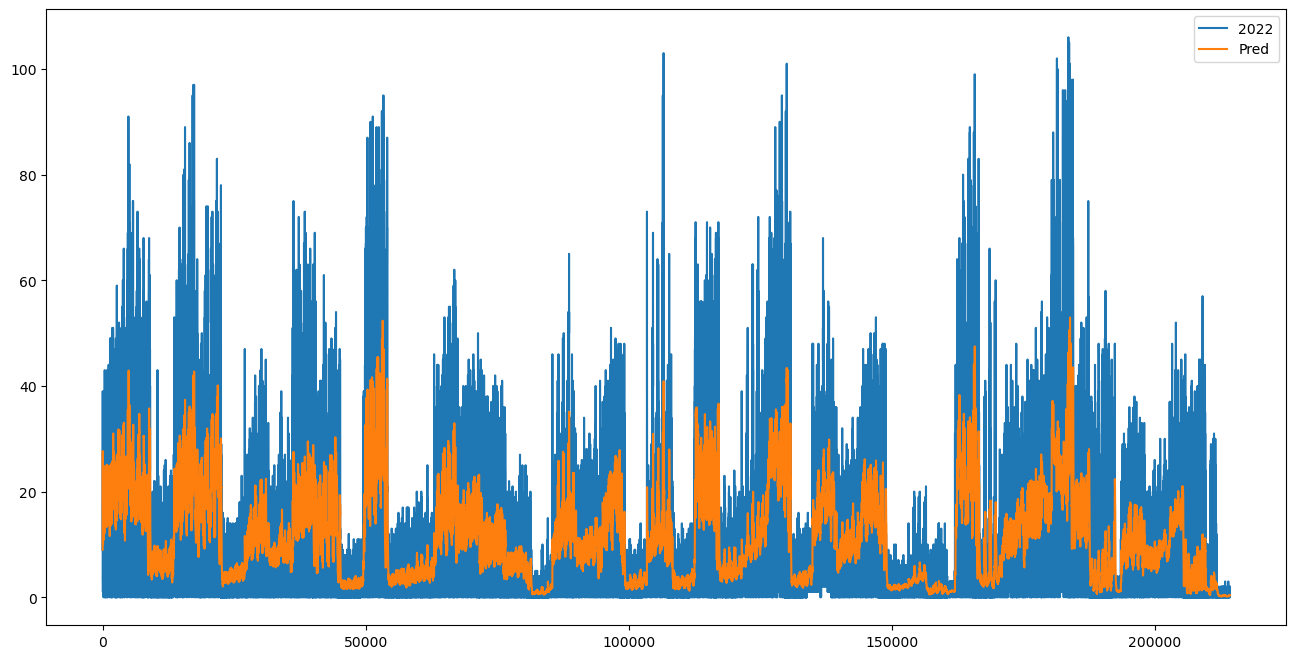

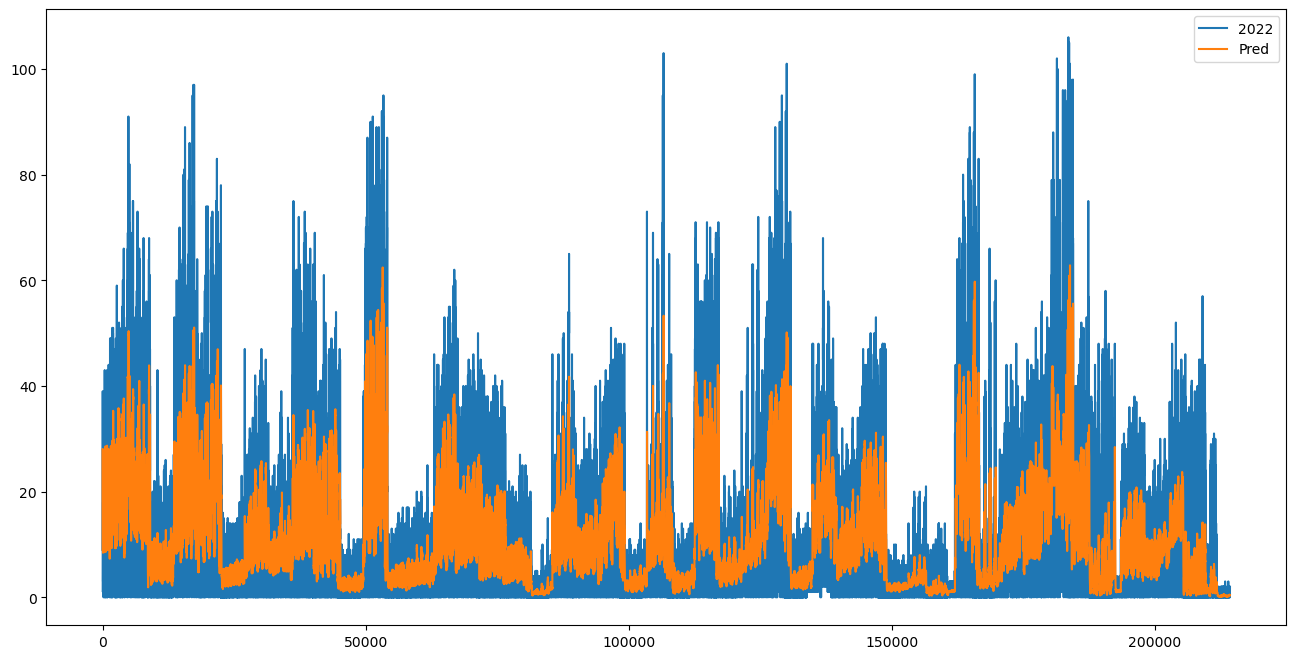

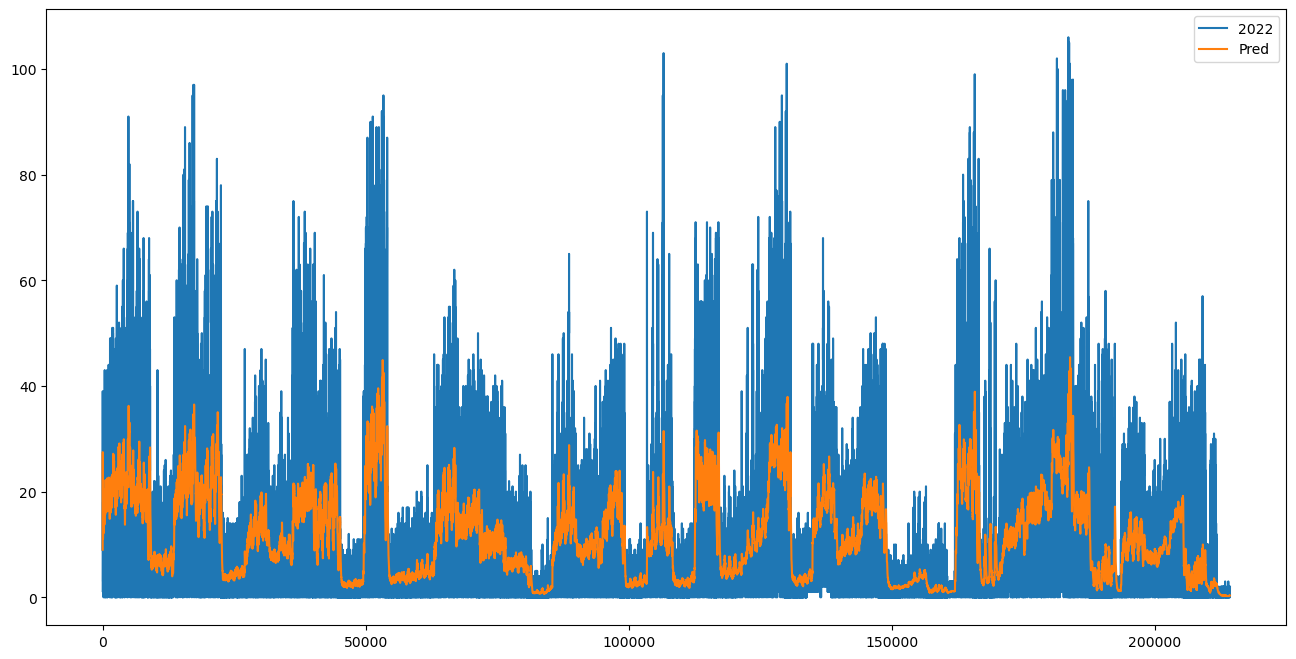

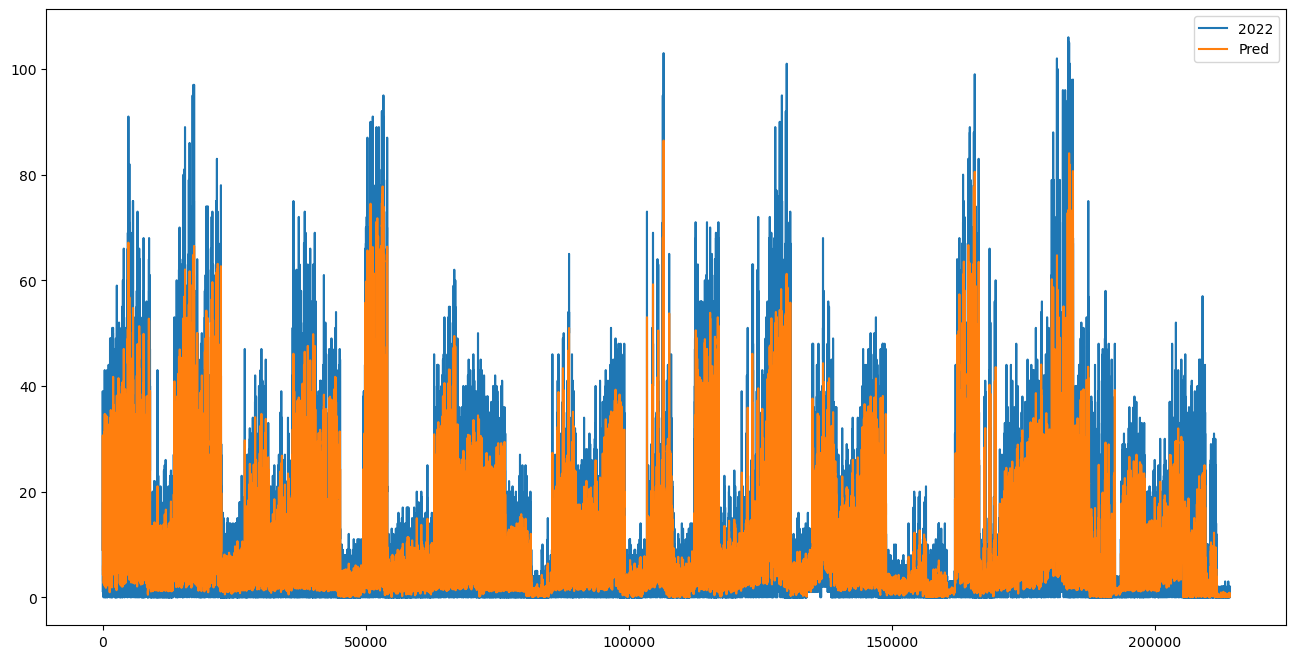

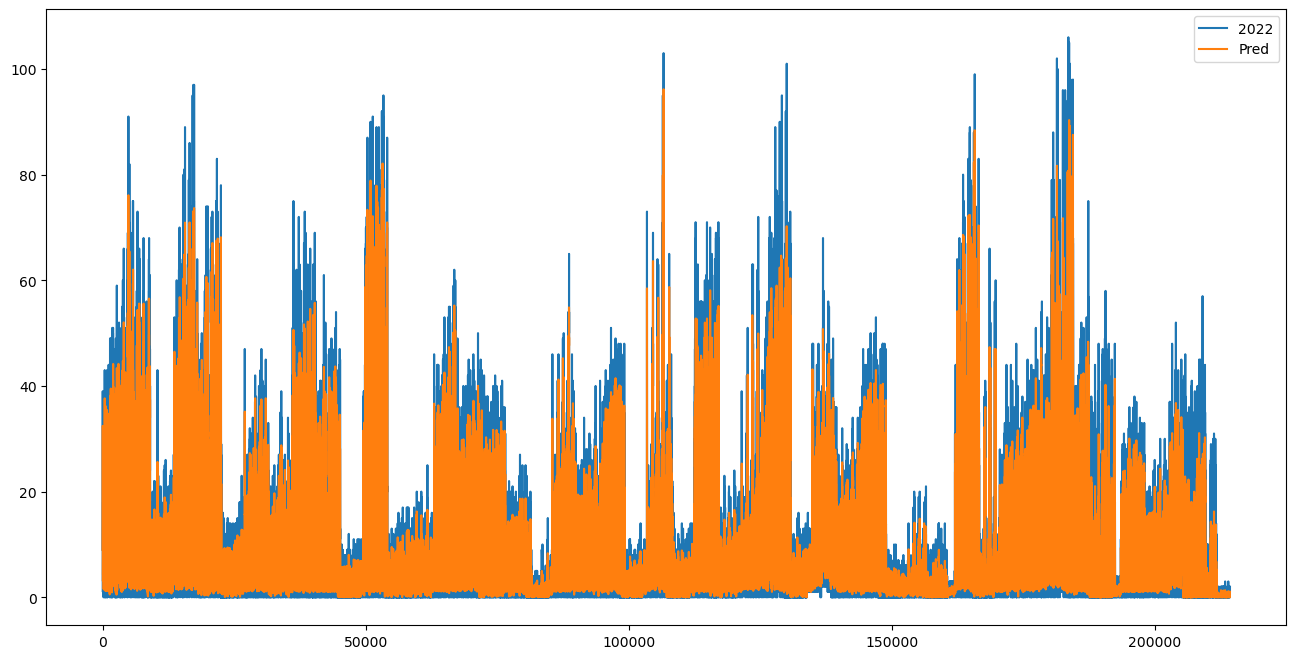

In [229]:
print(exponential_moving_averages_prev(ratios_jan, 100))
print(exponential_moving_averages_prev(ratios_jan, 50))
print(exponential_moving_averages_prev(ratios_jan, 200))
print(exponential_moving_averages_prev(ratios_jan, 10))
print(exponential_moving_averages_prev(ratios_jan, 5))